In [5]:
# import sys
# from pathlib import Path

# # Get the absolute path to the project root
# notebook_path = Path('/Users/nirmal/Documents/np_research/ManGo_code/ManGo')
# project_root = str(notebook_path)

# # Add the project root to Python path if it's not already there
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

# # Now you can import your module
# from src.models.mg_rig import RobustRegressor

# # Verify the import worked
# print(f"Project root: {project_root}")
# print(f"Available at: {RobustRegressor.__module__}")

In [6]:
# import logging
# # logging.basicConfig(
# #     level=logging.ERROR,
# #     format=" %(name)s | %(levelname)s | %(message)s"
# # )


# # logging.basicConfig(level=logging.ERROR)

# from machinegnostics.magcal.util.logging import get_logger

# logger = get_logger('PolynomialRegressor', level=logging.INFO)
# # logger.disabled = True  # Disable logging

2025-09-24 09:57:18,786 | PolynomialRegressor | INFO | PolynomialRegressor initialized:
2025-09-24 09:57:18,786 | PolynomialRegressor | INFO | DataProcessLayerBase initialized.
2025-09-24 09:57:18,787 | PolynomialRegressor | INFO | DataProcessRobustRegressor initialized.
2025-09-24 09:57:18,787 | PolynomialRegressor | DEBUG | PolynomialRegressor initialized.
2025-09-24 09:57:18,793 | PolynomialRegressor | INFO | Starting fit process.
2025-09-24 09:57:18,793 | PolynomialRegressor | INFO | Starting fit process for DataProcessRobustRegressor.
2025-09-24 09:57:18,794 | PolynomialRegressor | INFO | Starting fit input/output processing.
2025-09-24 09:57:18,794 | PolynomialRegressor | INFO | Checking input X of type: <class 'numpy.ndarray'>
2025-09-24 09:57:18,794 | PolynomialRegressor | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2025-09-24 09:57:18,795 | PolynomialRegressor | INFO | Checking target y of type: <class 'numpy.ndarray'>
2025-09-24 09:57:18,795 | Poly

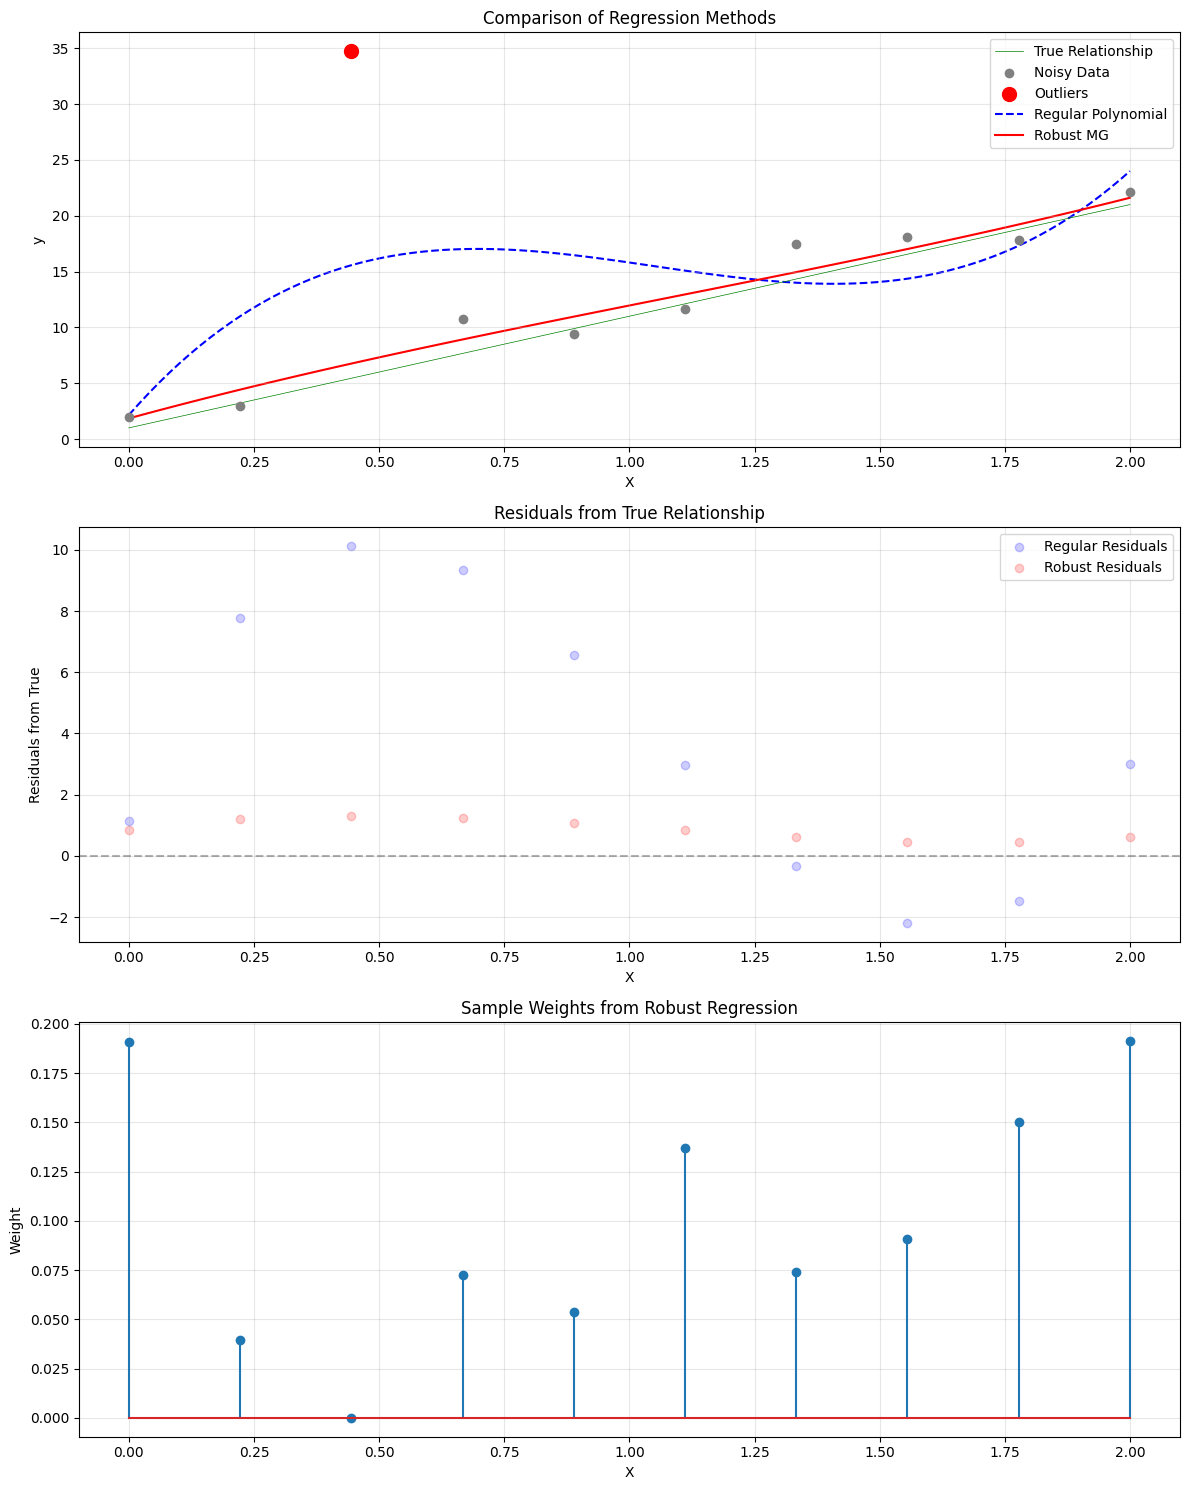

Coefficients:
True:     [1, 2]
Regular:  [  0.          51.13182115 -54.84299636  17.369313  ]
Robust MG: [ 1.85157289 12.20226958 -3.02410527  0.93136245]

MSE against true relationship (excluding outliers):
Regular Polynomial: 38.5847
Robust MG:         0.9911


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Generate clean data
X = np.linspace(0, 2, 10).reshape(-1, 1)
y_clean = 10 * X.ravel() + 1  # True linear relationship

# Add controlled noise and outliers
noise = np.random.normal(0, 2, 10)
y_noisy = y_clean + noise
# y_noisy[2] += [8.0]  # Add outliers
y_noisy[2] = y_noisy[2] + 28.0 

# Create test points for smooth curve
X_test = np.linspace(0, 2, 100).reshape(-1, 1)

# Fit models
degree = 3  # Using degree 1 for linear relationship
# Regular polynomial regression
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X, y_noisy)
y_pred_regular = poly_reg.predict(X)
y_pred_regular_test = poly_reg.predict(X_test)

# Fit robust Machine Gnostics regression
mg_model = PolynomialRegressor(degree=degree, tol=10-8, verbose=True)
# mg_model.logger.disabled = True  # Disable logging during fit
mg_model.fit(X, y_noisy)
y_pred_robust = mg_model.predict(X)
y_pred_robust_test = mg_model.predict(X_test)

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot regression curves
ax1.plot(X, y_clean, 'g-', label='True Relationship', linewidth=0.5)
ax1.scatter(X, y_noisy, color='gray', label='Noisy Data', zorder=2)
ax1.scatter(X[2], y_noisy[2], color='red', s=100, label='Outliers', zorder=3)
ax1.plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
ax1.plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.set_title('Comparison of Regression Methods')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot residuals from true relationship
residuals_regular = y_pred_regular - y_clean
residuals_robust = y_pred_robust - y_clean
ax2.scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.2)
ax2.scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('X')
ax2.set_ylabel('Residuals from True')
ax2.set_title('Residuals from True Relationship')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot sample weights
ax3.stem(X.ravel(), mg_model.weights, label='MG Weights')
ax3.set_xlabel('X')
ax3.set_ylabel('Weight')
ax3.set_title('Sample Weights from Robust Regression')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance metrics
print("Coefficients:")
print(f"True:     [1, 2]")
print(f"Regular:  {poly_reg.named_steps['linearregression'].coef_}")
print(f"Robust MG: {mg_model.coefficients}")

# Calculate MSE against true relationship
mse_regular = np.mean((y_pred_regular[:-2] - y_clean[:-2])**2)
mse_robust = np.mean((y_pred_robust[:-2] - y_clean[:-2])**2)
print("\nMSE against true relationship (excluding outliers):")
print(f"Regular Polynomial: {mse_regular:.4f}")
print(f"Robust MG:         {mse_robust:.4f}")

In [8]:
from machinegnostics.metrics.correlation import correlation

# print shape of y_clean and X
print(f"\ny_clean shape: {y_clean.flatten().shape}, X shape: {X.shape}")

gcorr = correlation(y_clean, X)
print(f"\nCorrelation between X and true y: {gcorr:.4f}")

gcorr_noisey = correlation(y_noisy.flatten(), X, case='i')
print(f"Correlation between X and noisy y: {gcorr_noisey:.4f}")

2025-09-24 09:57:19,123 | correlation | WARNING | Data 1 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:19,151 | correlation | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:19,224 | correlation | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.



y_clean shape: (10,), X shape: (10, 1)

Correlation between X and true y: 1.0000
Correlation between X and noisy y: 0.9817


In [9]:
# from machinegnostics.magcal import EGDF

# egdf_1 = EGDF(verbose=True, catch=True)
# egdf_1.fit(y_noisy.flatten(),plot=True)

# egdf_2 = EGDF(verbose=True, catch=True)
# egdf_2.fit(y_clean.flatten(), plot=True)

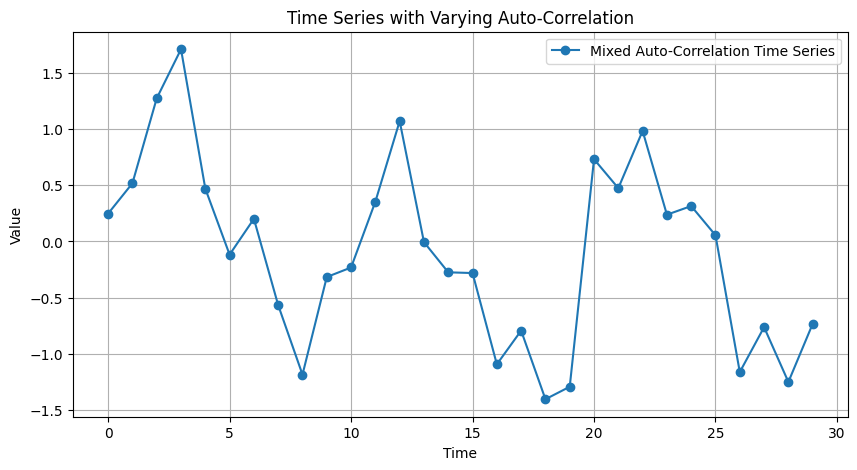

Auto-correlation with lag=0: 1.0
Auto-correlation with lag=1: 0.9972084104514682
Auto-correlation with lag=2: 0.9931210149064374
Auto-correlation with lag=3: 0.9910004556314982
Auto-correlation with lag=4: 0.988071628353665
Auto-correlation with lag=5: 0.9884760924253573


In [10]:
# Example of time series with varying auto-correlation
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.metrics.auto_correlation import auto_correlation

# Create a time series with a mix of periodicity and randomness
np.random.seed(42)  # For reproducibility
time_series = np.linspace(0, 29, 30)  # Time points
values = np.sin(0.2 * np.pi * time_series) + np.random.normal(0, 0.5, 30)  # Sine wave with noise

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series, values, marker='o', label='Mixed Auto-Correlation Time Series')
plt.title('Time Series with Varying Auto-Correlation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Compute auto-correlation for different lags
for lag in range(0, 6):
    auto_corr = auto_correlation(values, lag=lag)
    print(f"Auto-correlation with lag={lag}: {auto_corr}")

In [11]:
import numpy as np
import pandas as pd
from machinegnostics.metrics.auto_covariance import auto_covariance
from machinegnostics.metrics.auto_correlation import auto_correlation
from machinegnostics.metrics.cross_variance import cross_covariance
from machinegnostics.metrics.variance import variance
from machinegnostics.metrics.correlation import correlation

# Generate synthetic data
np.random.seed(42)
data_1 = np.random.normal(0, 1, 100)  # Random normal data
data_2 = np.random.normal(0, 1, 100)  # Another random normal data
data_3 = np.linspace(1, 10, 100)      # Linearly increasing data
data_4 = np.ones(100)                 # Constant data

# Test cases
test_cases = [
    ("Random Normal vs Random Normal", data_1, data_2),
    ("Random Normal vs Linear", data_1, data_3),
    ("Random Normal vs Constant", data_1, data_4),
    ("Linear vs Constant", data_3, data_4),
    ("Constant vs Constant", data_4, data_4),
]

# Initialize results
results = []

# Compute metrics for each test case
for description, d1, d2 in test_cases:
    try:
        # Gnostic metrics
        auto_cov = auto_covariance(d1, lag=1, case='i')
        auto_corr = auto_correlation(d1, lag=1, case='i')
        cross_cov = cross_covariance(d1, d2, case='i')
        var_1 = variance(d1, case='i')
        var_2 = variance(d2, case='i')
        corr = correlation(d1, d2, case='i')

        # Statistical metrics
        mean_1 = np.mean(d1)
        mean_2 = np.mean(d2)
        std_1 = np.std(d1)
        std_2 = np.std(d2)
        var_stat_1 = np.var(d1)
        var_stat_2 = np.var(d2)
    except Exception as e:
        auto_cov = auto_corr = cross_cov = var_1 = var_2 = corr = f"Error: {e}"
        mean_1 = mean_2 = std_1 = std_2 = var_stat_1 = var_stat_2 = f"Error: {e}"

    results.append({
        "Description": description,
        "Auto Covariance": auto_cov,
        "Auto Correlation": auto_corr,
        "Cross Covariance": cross_cov,
        "Variance (Gnostic, Data 1)": var_1,
        "Variance (Gnostic, Data 2)": var_2,
        "Correlation (Gnostic)": corr,
        "Mean (Data 1)": mean_1,
        "Mean (Data 2)": mean_2,
        "Std Dev (Data 1)": std_1,
        "Std Dev (Data 2)": std_2,
        "Variance (Stat, Data 1)": var_stat_1,
        "Variance (Stat, Data 2)": var_stat_2,
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results as a table
print(results_df.to_string(index=False))

2025-09-24 09:57:22,397 | cross_covariance | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:22,533 | correlation | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,516 | cross_covariance | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,731 | correlation | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,755 | auto_covariance | WARNING | Data is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,760 | auto_covariance | WARNING | Lagged data is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,787 | auto_correlation | WARNING | Data is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,793 | auto_correlation | WARNING | Lagged data is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:23,821 | cross_covariance | WARNING |

                   Description  Auto Covariance  Auto Correlation  Cross Covariance  Variance (Gnostic, Data 1)  Variance (Gnostic, Data 2)  Correlation (Gnostic)  Mean (Data 1)  Mean (Data 2)  Std Dev (Data 1)  Std Dev (Data 2)  Variance (Stat, Data 1)  Variance (Stat, Data 2)
Random Normal vs Random Normal     2.377767e-01          0.998345      2.383128e-01                5.314216e-01                5.401190e-01           9.909509e-01      -0.103847       0.022305          0.903616          0.948889                 0.816522                 0.900390
       Random Normal vs Linear     2.377767e-01          0.998345      2.304581e-01                5.314216e-01                5.899688e-01           9.915541e-01      -0.103847       5.500000          0.903616          2.624188                 0.816522                 6.886364
     Random Normal vs Constant     2.377767e-01          0.998345      2.472806e-20                5.314216e-01                3.999983e-20           2.521172e-10 

In [12]:
results_df

Description  Auto Covariance  Auto Correlation  \
0  Random Normal vs Random Normal     2.377767e-01          0.998345   
1         Random Normal vs Linear     2.377767e-01          0.998345   
2       Random Normal vs Constant     2.377767e-01          0.998345   
3              Linear vs Constant     2.282541e-01          1.000000   
4            Constant vs Constant     4.040799e-20          1.000000   

   Cross Covariance  Variance (Gnostic, Data 1)  Variance (Gnostic, Data 2)  \
0      2.383128e-01                5.314216e-01                5.401190e-01   
1      2.304581e-01                5.314216e-01                5.899688e-01   
2      2.472806e-20                5.314216e-01                3.999983e-20   
3      1.688098e-20                5.899688e-01                3.999983e-20   
4      3.999983e-20                3.999983e-20                3.999983e-20   

   Correlation (Gnostic)  Mean (Data 1)  Mean (Data 2)  Std Dev (Data 1)  \
0           9.909509e-01      -0.103847       0.022305          0.903616   
1           9.915541e-01      -0.103847       5.500000          0.903616   
2           2.521172e-10      -0.103847       1.000000          0.903616   
3           1.780949e-10       5.500000       1.000000          2.624188   
4           1.000000e+00       1.000000       1.000000          0.000000   

   Std Dev (Data 2)  Variance (Stat, Data 1)  Variance (Stat, Data 2)  
0          0.948889                 0.816522                 0.900390  
1          2.624188                 0.816522                 6.886364  
2          0.000000                 0.816522                 0.000000  
3          0.000000                 6.886364                 0.000000  
4          0.000000                 0.000000                 0.000000

In [13]:
import numpy as np
from machinegnostics.metrics.auto_covariance import auto_covariance

# Generate a proper time series
np.random.seed(42)
time_series = np.sin(0.2 * np.pi * np.arange(30)) + np.random.normal(0, 0.5, 30)  # Sine wave with noise

# Define lag
lag = 5

# Compute Gnostic auto-covariance
gnostic_auto_covar = auto_covariance(time_series, lag=lag, case='i')

# Compute statistical auto-covariance
statistical_auto_covar = np.cov(time_series[:-lag], time_series[lag:])[0, 1]

# Print results
print(f"Time Series: {time_series}")
print(f"Gnostic Auto-Covariance (lag={lag}): {gnostic_auto_covar:.4f}")
print(f"Statistical Auto-Covariance (lag={lag}): {statistical_auto_covar:.4f}")

Time Series: [ 0.24835708  0.5186531   1.27490079  1.71257144  0.47070856 -0.11706848
  0.20182116 -0.56733915 -1.18579371 -0.31650523 -0.23170885  0.35492038
  1.07203765 -0.00558361 -0.27467366 -0.28114376 -1.09420081 -0.79393285
 -1.40506855 -1.2939371   0.73282438  0.4748971   0.98482062  0.23868242
  0.31559389  0.05546129 -1.16328204 -0.76320751 -1.25137586 -0.73363213]
Gnostic Auto-Covariance (lag=5): 0.2948
Statistical Auto-Covariance (lag=5): -0.3253


model coeff: [ 3.33139017 -7.88149425 17.3218359 ]


/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49127/226890915.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


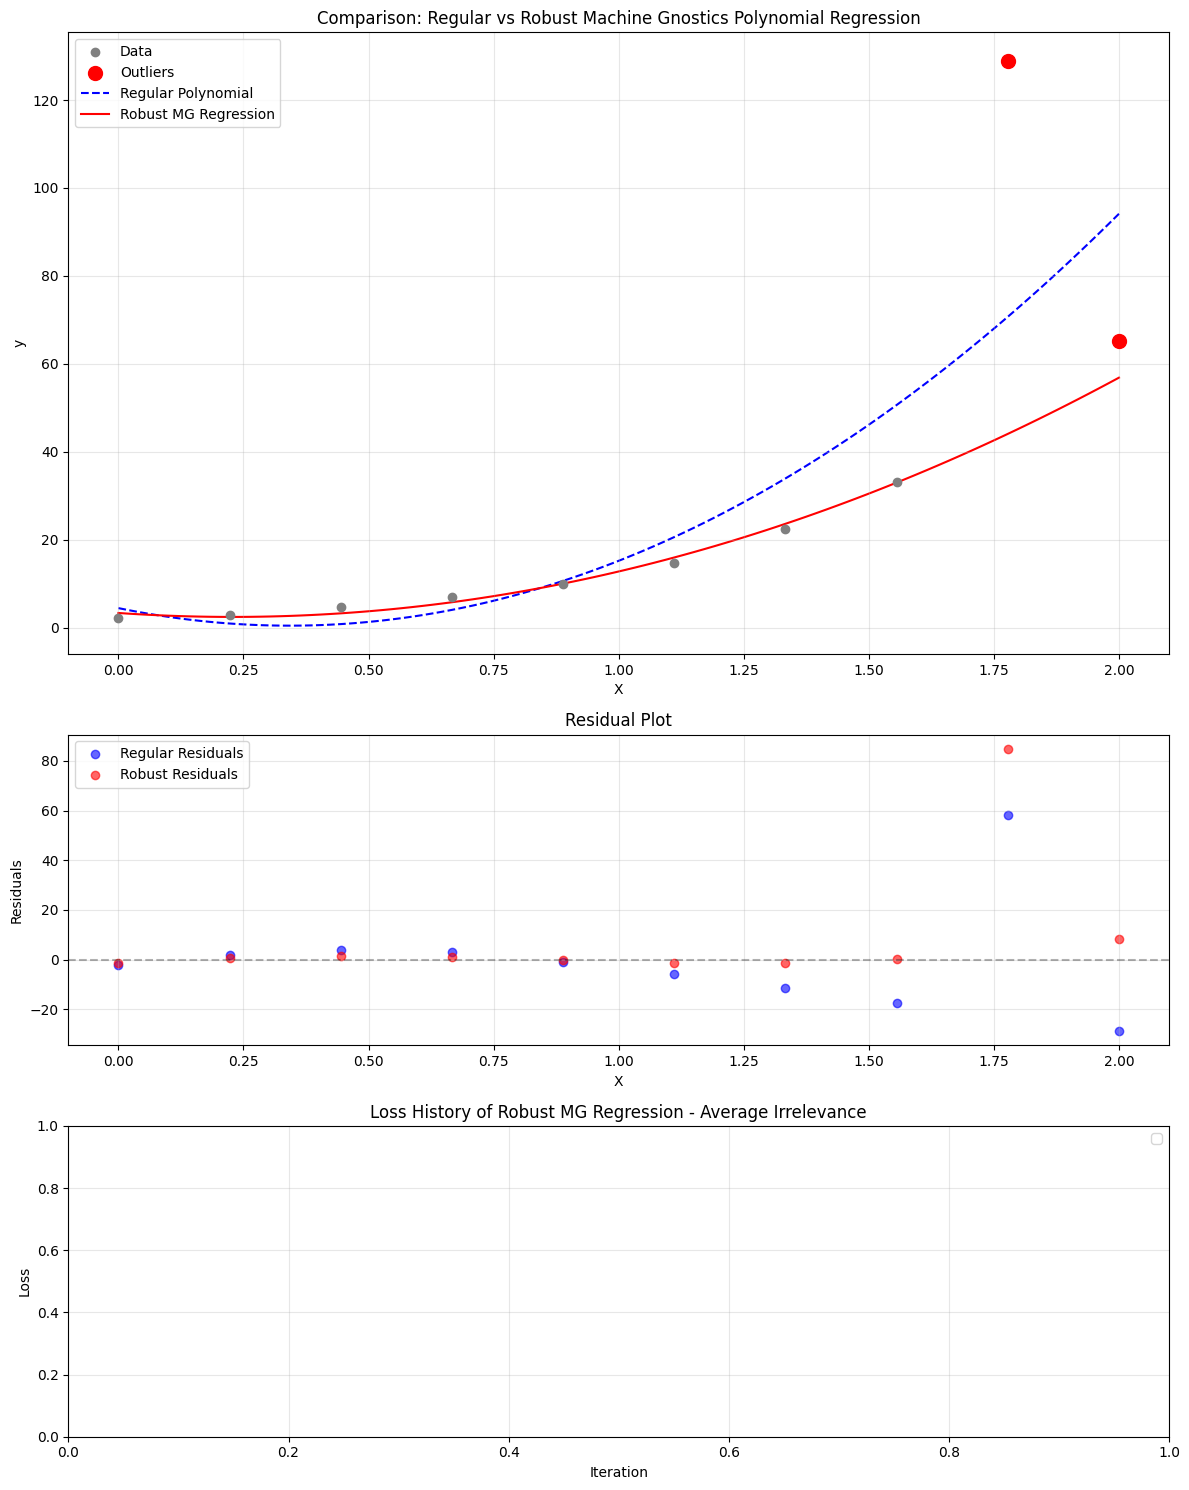

MSE (excluding outliers):
Regular Polynomial: 63.8383
Robust MG Regression: 1.0044

Max Absolute Residuals (excluding outliers):
Regular Polynomial: 17.5910
Robust MG Regression: 1.3305


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 2.0 * np.exp(1.8 * X.ravel()) + np.random.normal(0, 0.2, 10)
# y = 2*X +1
y[8:] += [80.0, -8.0]  # Add outliers
# Introduce outliers
# y[8:] += np.array([8.0, -80.0])  # one high outlier, one low outlier

# Create test points for smooth curve
X_test = np.linspace(0, 2, 100).reshape(-1, 1)

# Fit regular polynomial regression
degree = 2
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X, y)
y_pred_regular = poly_reg.predict(X)  # Predict on training points for residuals
y_pred_regular_test = poly_reg.predict(X_test)  # Predict on test points for curve

# Fit robust Machine Gnostics regression
mg_model = PolynomialRegressor(degree=degree)
mg_model.fit(X, y.flatten())
y_pred_robust = mg_model.predict(X)  # Predict on training points for residuals
y_pred_robust_test = mg_model.predict(X_test)  # Predict on test points for curve
print(f'model coeff: {mg_model.coefficients}')

# Calculate residuals
residuals_regular = y - y_pred_regular
residuals_robust = y - y_pred_robust

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[2, 1, 1])

# Plot regression curves
ax1.scatter(X, y, color='gray', label='Data', zorder=2)
ax1.scatter(X[8:], y[8:], color='red', s=100, label='Outliers', zorder=3)
ax1.plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
ax1.plot(X_test, y_pred_robust_test, 'r-', label='Robust MG Regression', zorder=1)
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.set_title('Comparison: Regular vs Robust Machine Gnostics Polynomial Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot residuals
ax2.scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.6)
ax2.scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.6)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('X')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.legend()
ax2.grid(True, alpha=0.3)

# plot history of loss
# ax3.plot(mg_model._history, color='red', label='Loss History - MG Regression')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Loss')
ax3.set_title('Loss History of Robust MG Regression - Average Irrelevance')

ax3.legend()
ax3.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print mean squared error for both methods (excluding outliers)
mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
print(f"MSE (excluding outliers):")
print(f"Regular Polynomial: {mse_regular:.4f}")
print(f"Robust MG Regression: {mse_robust:.4f}")

# Print max absolute residuals (excluding outliers)
max_resid_regular = np.max(np.abs(residuals_regular[:-2]))
max_resid_robust = np.max(np.abs(residuals_robust[:-2]))
print(f"\nMax Absolute Residuals (excluding outliers):")
print(f"Regular Polynomial: {max_resid_regular:.4f}")
print(f"Robust MG Regression: {max_resid_robust:.4f}")

In [15]:
residuals_regular

array([ -2.33765465,   2.0188571 ,   3.77687087,   2.90801455,
        -0.77713498,  -5.87109554, -11.57266353, -17.59102418,
        58.27194772, -28.82611735])

In [16]:
residuals_robust

array([-1.23204734e+00,  5.20650227e-01,  1.33051851e+00,  1.16918541e+00,
       -1.52772189e-01, -1.22787212e+00, -1.25491078e+00,  5.69266020e-02,
        8.49057652e+01,  8.44923562e+00])


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 375.9472
Ridge Regression:   393.6559
Lasso Regression:   374.0560
Robust MG:          257.4340

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 516.3775
Ridge Regression:   505.5366
Lasso Regression:   508.2516
Robust MG:          5.5653

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 518.3422
Ridge Regression:   489.9117
Lasso Regression:   513.7563
Robust MG:          37.0000

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 550.7217
Ridge Regression:   469.4905
Lasso Regression:   545.9007
Robust MG:          34.5630


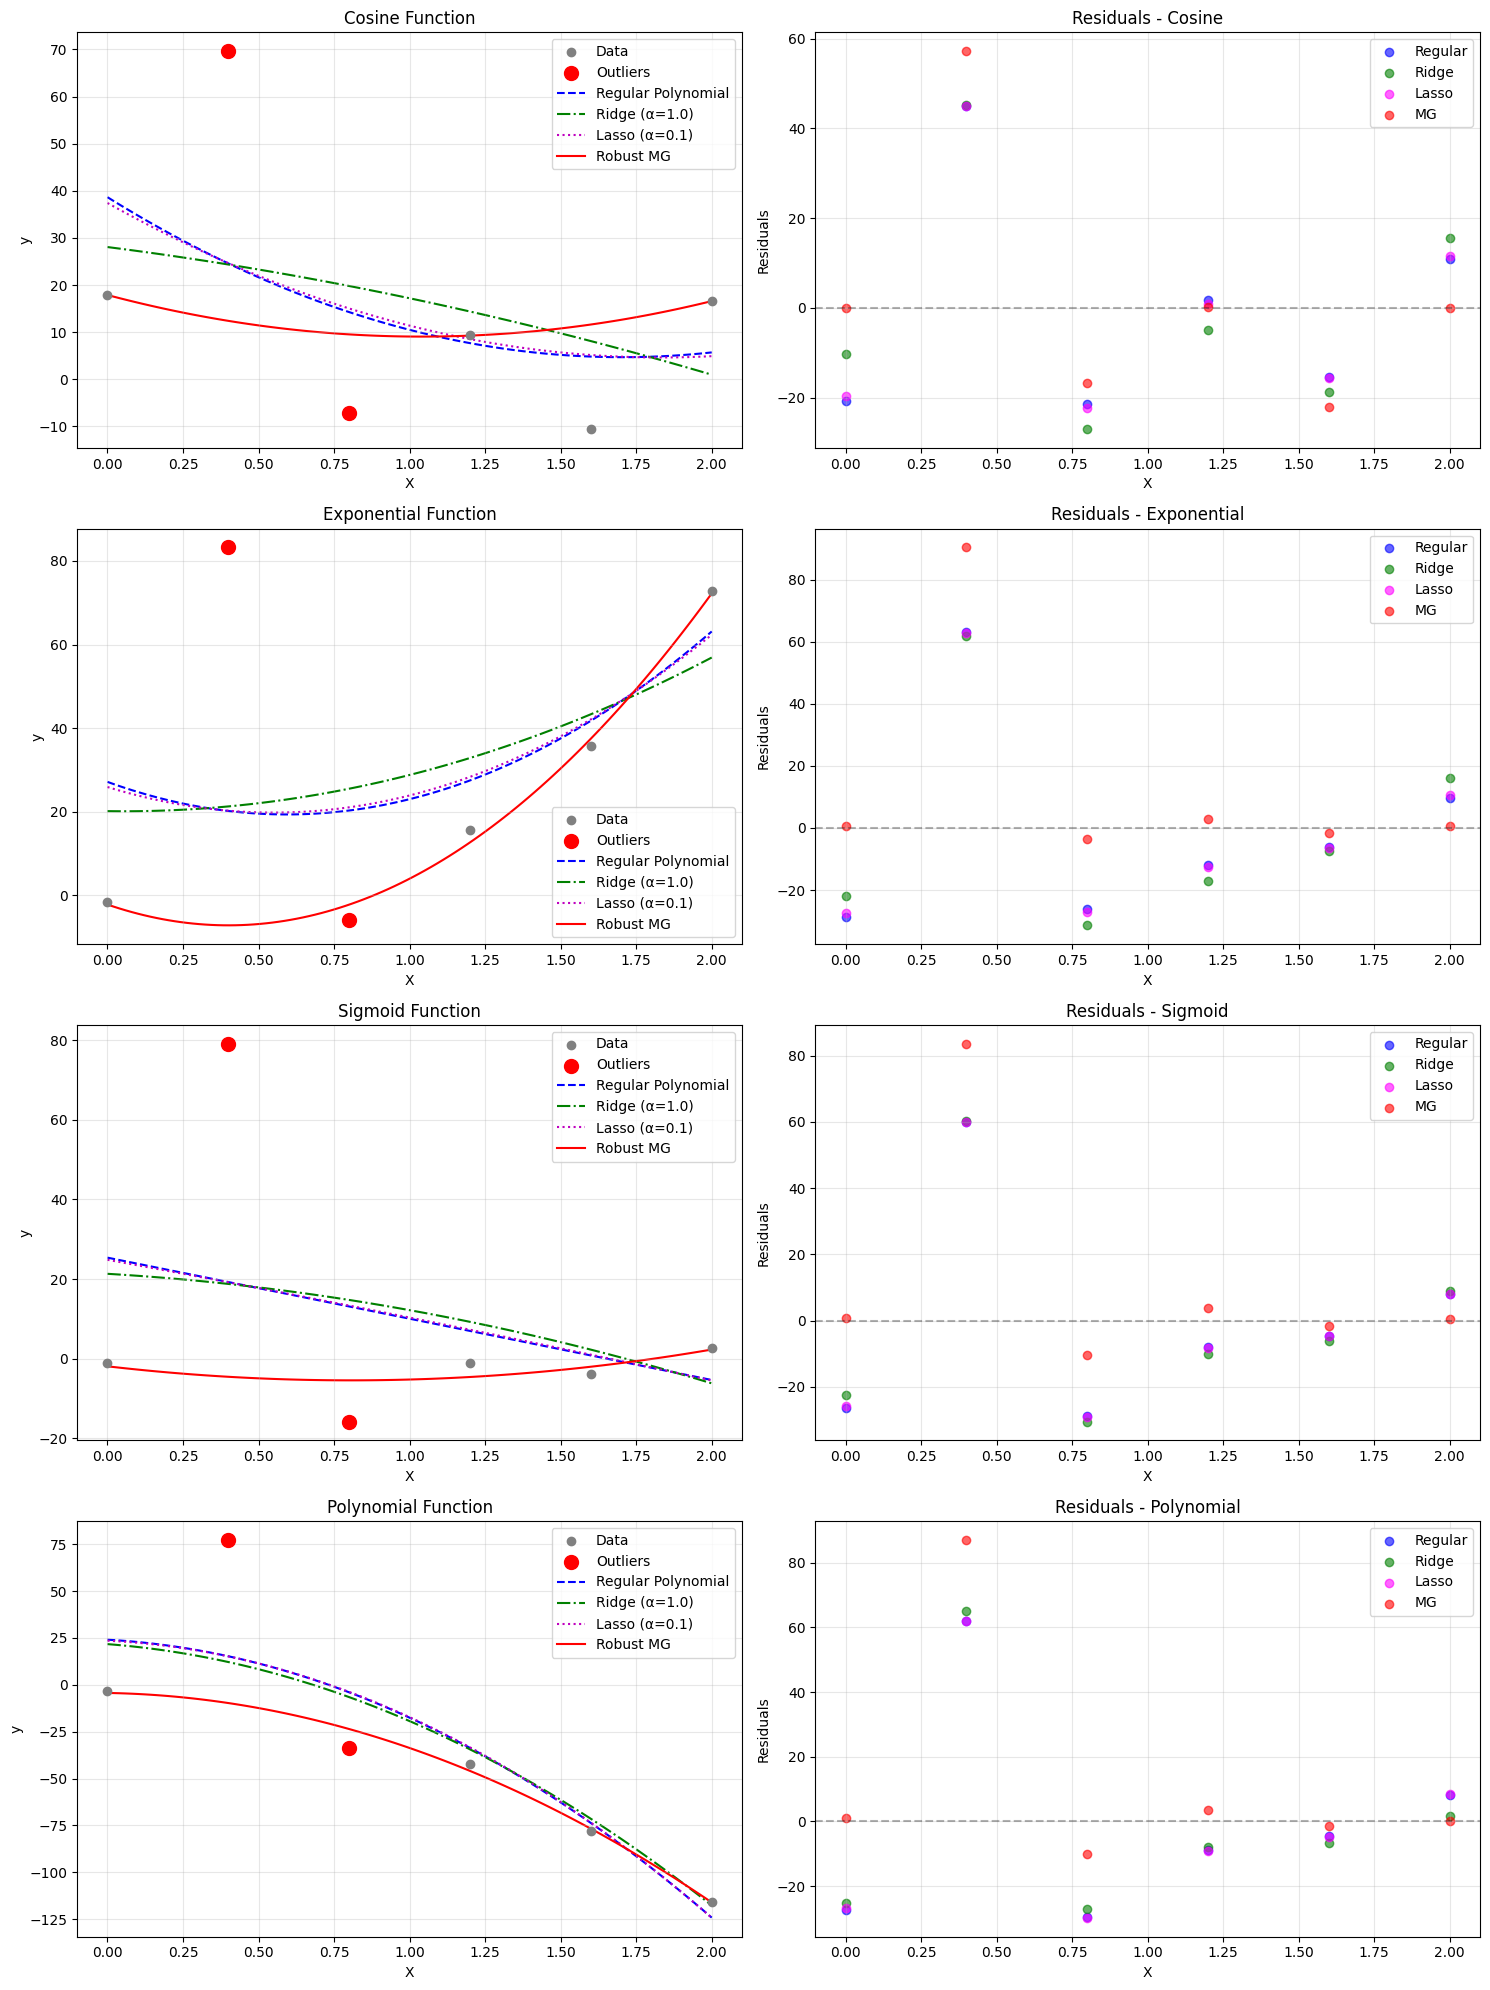

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Create multiple test functions
def generate_data(func_type, X, noise_level=1.8, outlier_positions=[1, 2], outlier_values=[80.0, -15.0]):
    if func_type == 'cosine':
        y = 15 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 1.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 0.05 * X.ravel()**3 - 30 * X.ravel()**2 + 1
    
    y = y + np.random.normal(0, noise_level, len(X))
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data - changed to 5 points
    X = np.linspace(0, 2, 6).reshape(-1, 1)  # 5 points total
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 2  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[[1, 2]], y[[1, 2]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.6)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.6)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 445.5874
Robust MG Regression: 548.8367

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 523.2084
Robust MG Regression: 751.0074

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 522.8897
Robust MG Regression: 804.6033

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 503.3894
Robust MG Regression: 784.5227


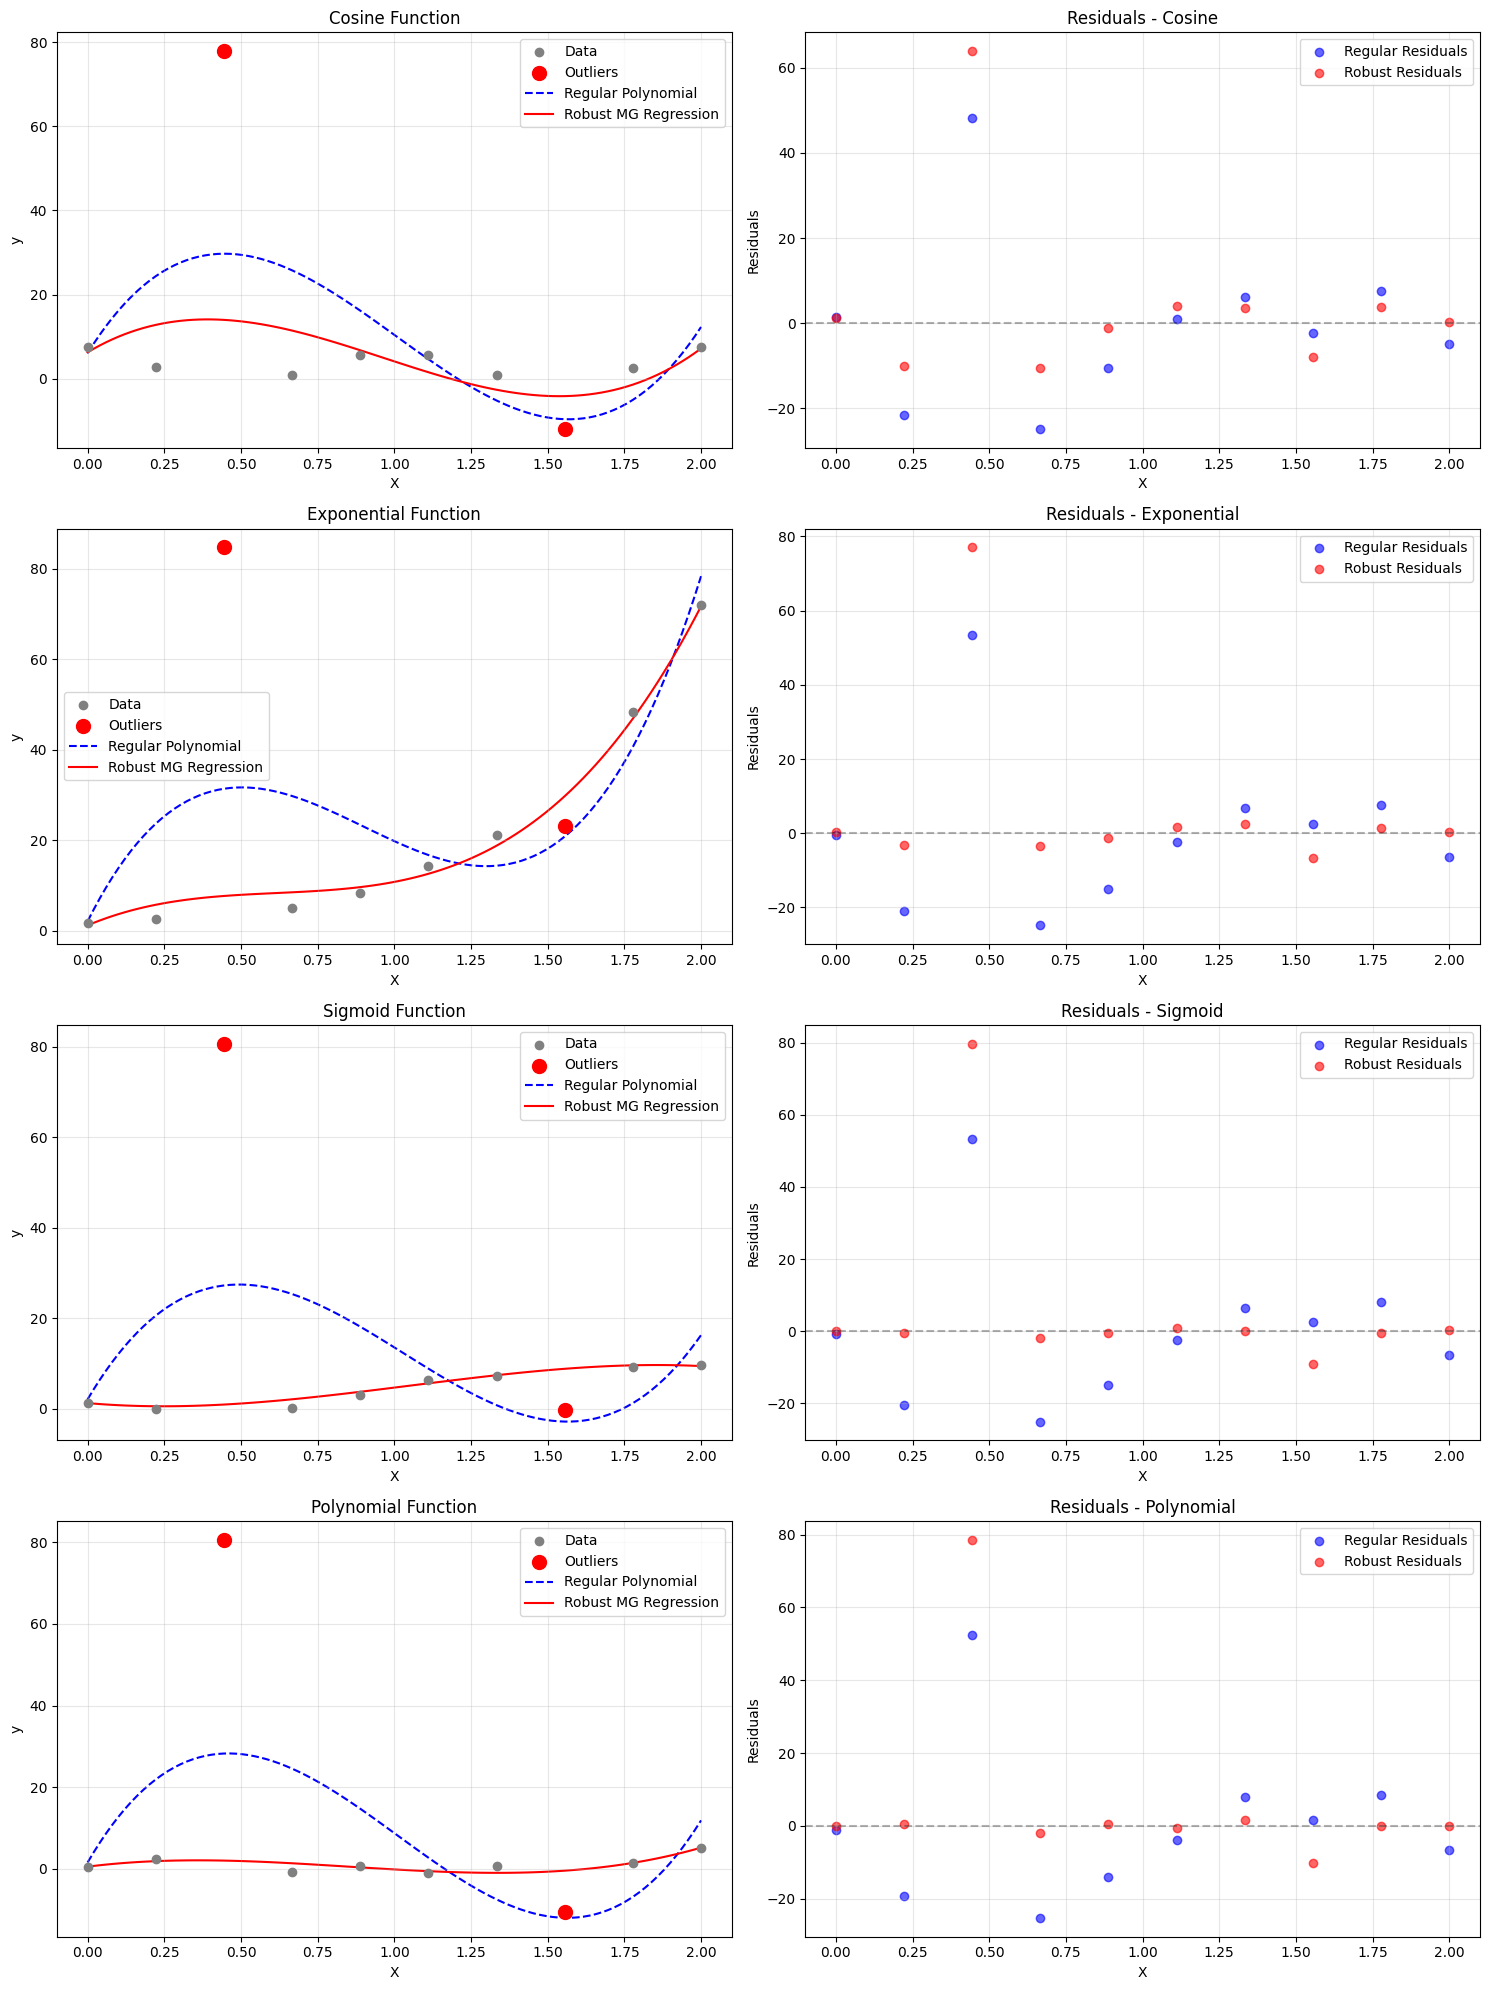

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)
outlier_positions=[2, 7]

# Create multiple test functions
def generate_data(func_type, X, noise_level=0.9, outlier_positions=outlier_positions, outlier_values=[80.0, -10.0]):
    if func_type == 'cosine':
        y = 5 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 10.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 2 * X.ravel()**3 - 3 * X.ravel()**2 + 1
    
    # Add noise
    y = y + np.random.normal(0, noise_level, len(X))
    
    # Add outliers
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 10).reshape(-1, 1)
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 3  # Increased degree for more complex functions
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[outlier_positions], y[outlier_positions], color='red', s=100, label='Outliers', zorder=3)
    # axes[i,0].scatter(X[8:], y[2,8], color='red', s=100, label='Outliers', zorder=3)
    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG Regression', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Print metrics
    mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
    mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Robust MG Regression: {mse_robust:.4f}")

plt.tight_layout()
plt.show()

/Users/nirmal/Documents/np_research/ManGo_code/ManGo/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+03, tolerance: 1.136e+00
  model = cd_fast.enet_coordinate_descent(



Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 69.6146
Ridge Regression:   169.2034
Lasso Regression:   170.8098
Robust MG:          112.3202

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 0.0004
Ridge Regression:   0.0906
Lasso Regression:   1.1154
Robust MG:          0.0008

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 1.1881
Ridge Regression:   9.0339
Lasso Regression:   9.8463
Robust MG:          1.8310

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 0.0000
Ridge Regression:   0.2884
Lasso Regression:   1.1419
Robust MG:          0.0000


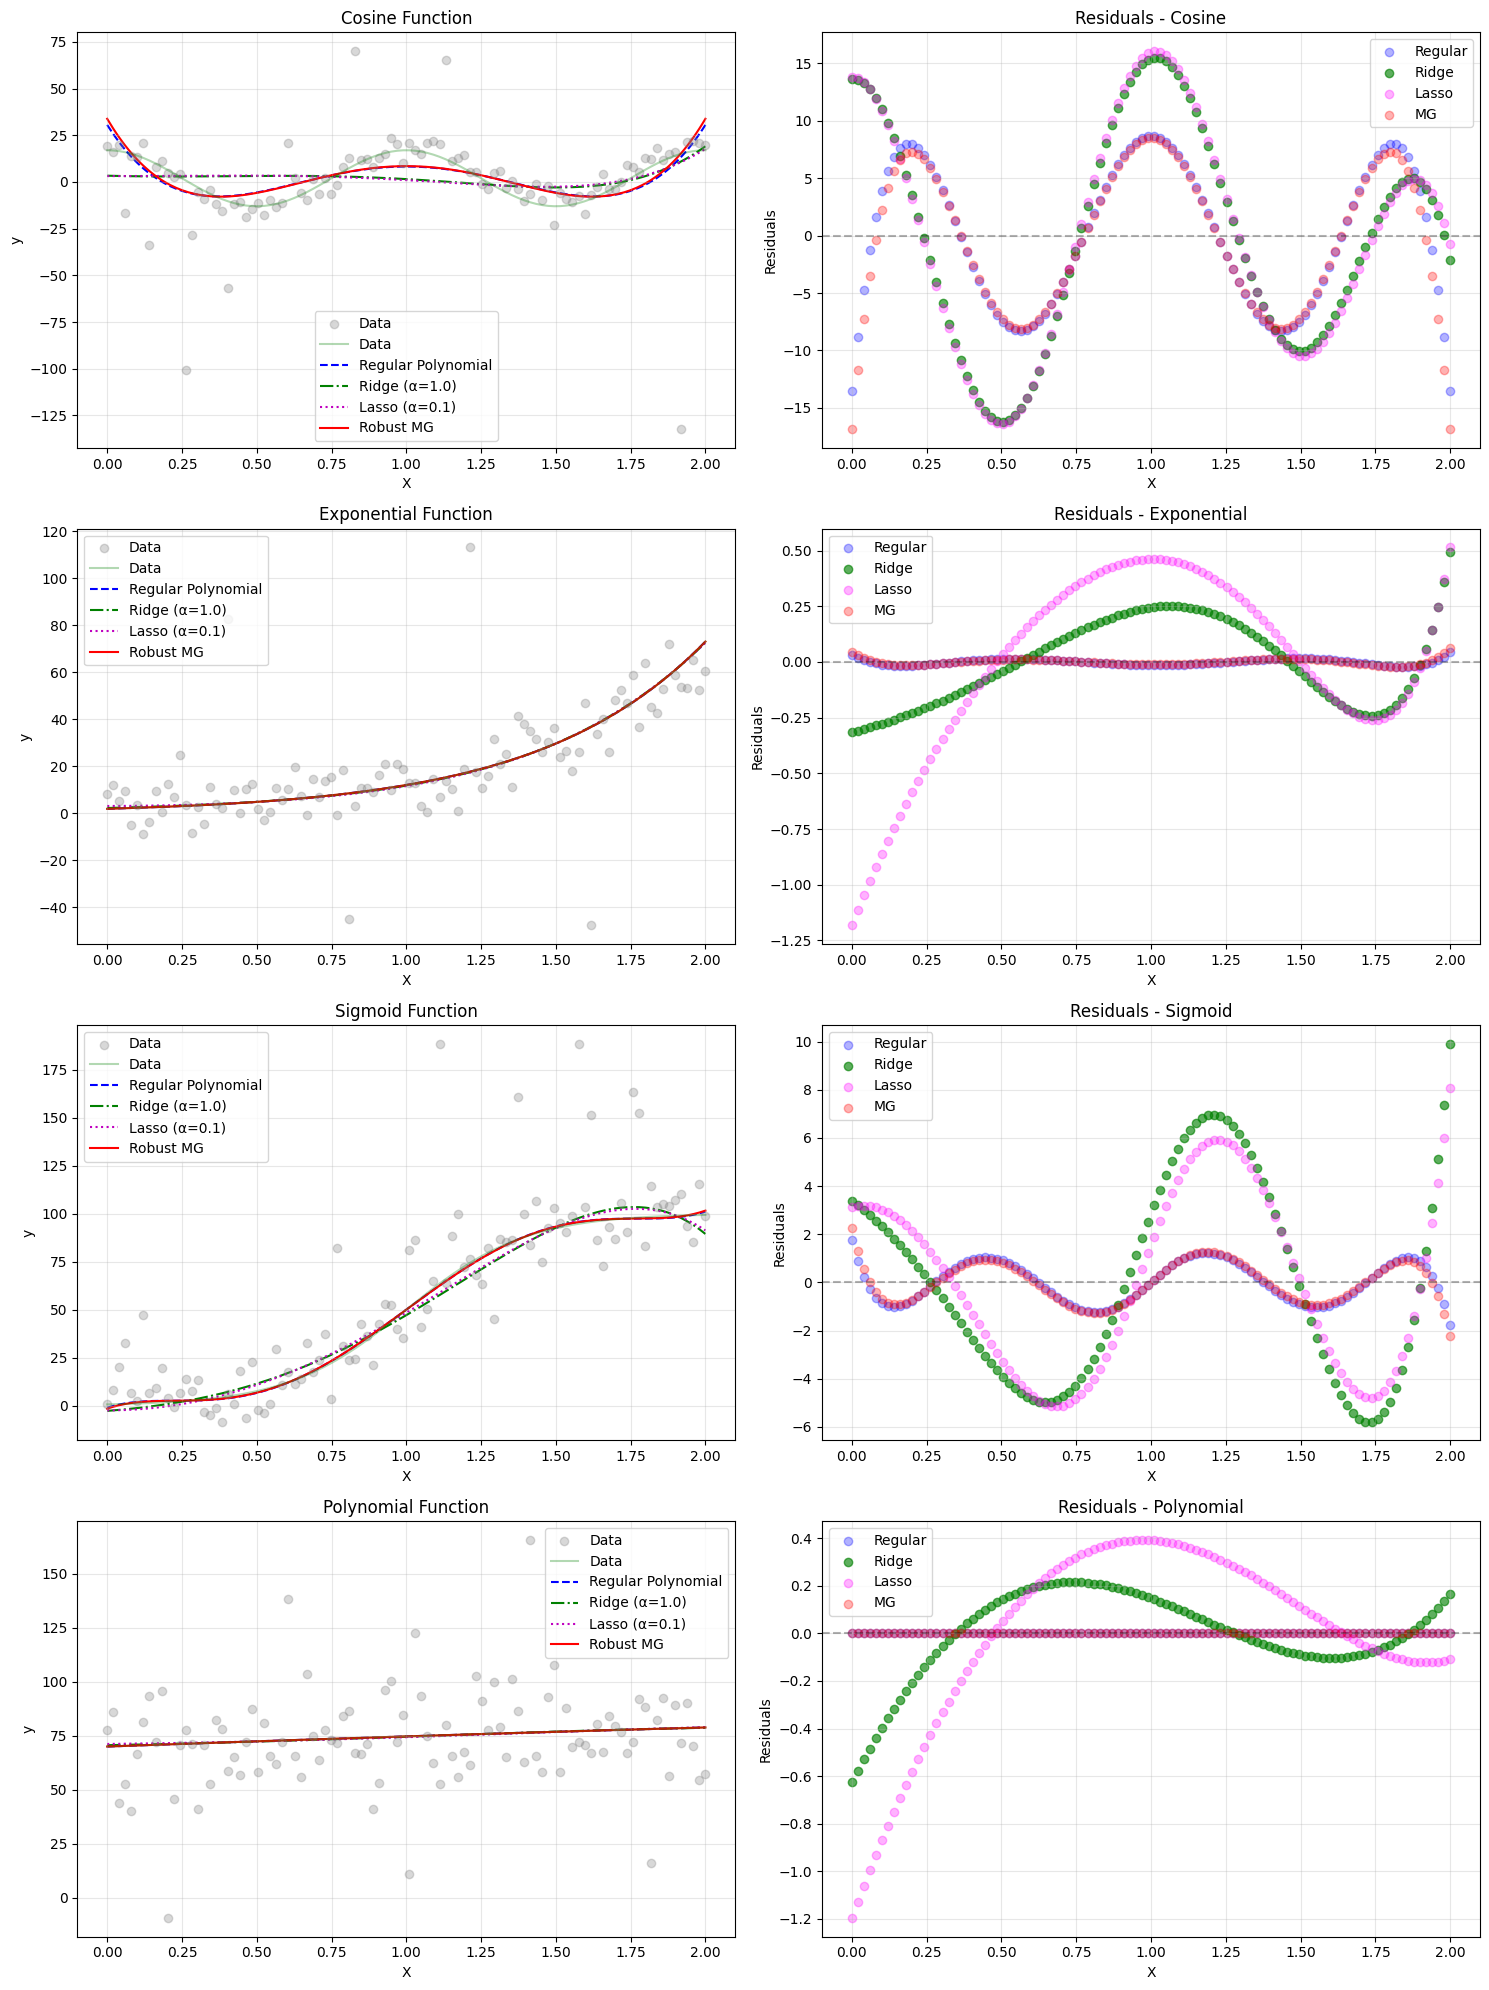

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(func_type, X, params):
    """Generate synthetic data with different profiles."""
    # Base function
    if func_type == 'cosine':
        y = params['amplitude'] * np.cos(params['frequency'] * X.ravel()) + params['offset']
    elif func_type == 'exponential':
        y = params['amplitude'] * np.exp(params['rate'] * X.ravel())
    elif func_type == 'sigmoid':
        y = params['amplitude'] / (1 + np.exp(-params['rate'] * (X.ravel() - params['midpoint'])))
    elif func_type == 'polynomial':
        y = (params['a'] * X.ravel()**3 + 
             params['b'] * X.ravel()**2 + 
             params['c'] * X.ravel() + 
             params['d'])
    
    # Add base noise
    y_ = y + np.random.normal(0, params['noise_level'], len(X))
    
    # Add trend if specified
    if params['trend'] != 0:
        y_ += params['trend'] * X.ravel()
    
    # Add outliers
    if params['outlier_mode'] == 'random':
        # Random outliers
        n_outliers = int(len(X) * params['outlier_fraction'])
        outlier_idx = np.random.choice(len(X), n_outliers, replace=False)
        outlier_values = np.random.normal(params['outlier_mean'], 
                                        params['outlier_std'], 
                                        n_outliers)
        y_[outlier_idx] += outlier_values
    elif params['outlier_mode'] == 'systematic':
        # Systematic outliers at specific positions
        y_[params['outlier_positions']] += params['outlier_values']
    
    return y, y_

# Define test profiles with different characteristics
test_profiles = {
    'cosine': {
        'amplitude': 15,
        'frequency': 2 * np.pi,
        'offset': 2,
        'noise_level': 5,
        'trend': 2,  # Linear trend
        'outlier_mode': 'random',
        'outlier_fraction': 0.1,
        'outlier_mean': 0,
        'outlier_std': 50
    },
    'exponential': {
        'amplitude': 2,
        'rate': 1.8,
        'noise_level': 8,
        'trend': -1,  # Negative trend
        'outlier_mode': 'systematic',
        'outlier_positions': [20, 40, 60, 80],
        'outlier_values': [80, -60, 100, -80]
    },
    'sigmoid': {
        'amplitude': 100,
        'rate': 5,
        'midpoint': 1,
        'noise_level': 10,
        'trend': 0,
        'outlier_mode': 'random',
        'outlier_fraction': 0.15,
        'outlier_mean': 50,
        'outlier_std': 30
    },
    'polynomial': {
        'a': 0.005,
        'b': -0.3,
        'c': 5,
        'd': 70,
        'noise_level': 15,
        'trend': 1.5,
        'outlier_mode': 'systematic',
        'outlier_positions': [10, 30, 50, 70, 90],
        'outlier_values': [-60, 80, -70, 90, -50]
    }
}

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 100).reshape(-1, 1)
    y, y_ = generate_data(func, X, test_profiles[func])
    X_test = np.linspace(0, 2, 200).reshape(-1, 1)
    
    # ... rest of the code remains the same ...
    
    # Fit models
    degree = 5  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y_, color='gray', label='Data', zorder=2, alpha=0.3)
    # true data
    axes[i,0].plot(X, y, color='g', label='Data', zorder=2, alpha=0.3)
    # true data)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.3)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.63)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.3)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.3)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

In [20]:
def generate_data(func_type, X, params):
    """Generate synthetic data with different profiles and outlier clusters."""
    # Base function
    if func_type == 'cosine':
        y = params['amplitude'] * np.cos(params['frequency'] * X.ravel()) + params['offset']
    elif func_type == 'exponential':
        y = params['amplitude'] * np.exp(params['rate'] * X.ravel())
    elif func_type == 'sigmoid':
        y = params['amplitude'] / (1 + np.exp(-params['rate'] * (X.ravel() - params['midpoint'])))
    elif func_type == 'polynomial':
        y = (params['a'] * X.ravel()**3 + 
             params['b'] * X.ravel()**2 + 
             params['c'] * X.ravel() + 
             params['d'])
    
    # Add base noise
    y_ = y + np.random.normal(0, params['noise_level'], len(X))
    
    # Add trend if specified
    if params['trend'] != 0:
        y_ += params['trend'] * X.ravel()
    
    # Add outlier clusters
    for cluster in params['outlier_clusters']:
        center = cluster['center']
        width = cluster['width']
        strength = cluster['strength']
        
        # Create cluster of outliers
        cluster_mask = np.abs(X.ravel() - center) < width/2
        n_points = np.sum(cluster_mask)
        
        if n_points > 0:
            # Generate cluster noise
            cluster_noise = np.random.normal(
                strength['mean'], 
                strength['std'], 
                n_points
            )
            y[cluster_mask] += cluster_noise
    
    return y, y_

# Define test profiles with outlier clusters
test_profiles = {
    'cosine': {
        'amplitude': 15,
        'frequency': 2 * np.pi,
        'offset': 2,
        'noise_level': 5,
        'trend': 2,
        'outlier_clusters': [
            {'center': 0.5, 'width': 0.2, 'strength': {'mean': 30, 'std': 10}},
            # {'center': 1.2, 'width': 0.3, 'strength': {'mean': -40, 'std': 15}},
            # {'center': 1.8, 'width': 0.2, 'strength': {'mean': 60, 'std': 12}}
        ]
    },
    'exponential': {
        'amplitude': 2,
        'rate': 1.8,
        'noise_level': 8,
        'trend': -1,
        'outlier_clusters': [
            # {'center': 0.3, 'width': 0.25, 'strength': {'mean': -60, 'std': 15}},
            {'center': 1.0, 'width': 0.2, 'strength': {'mean': 80, 'std': 20}},
            # {'center': 1.7, 'width': 0.3, 'strength': {'mean': -70, 'std': 18}}
        ]
    },
    'sigmoid': {
        'amplitude': 100,
        'rate': 5,
        'midpoint': 1,
        'noise_level': 10,
        'trend': 0,
        'outlier_clusters': [
            {'center': 0.4, 'width': 0.2, 'strength': {'mean': 90, 'std': 15}},
            # {'center': 1.1, 'width': 0.25, 'strength': {'mean': -50, 'std': 12}},
            # {'center': 1.6, 'width': 0.3, 'strength': {'mean': 40, 'std': 10}}
        ]
    },
    'polynomial': {
        'a': 0.005,
        'b': -0.3,
        'c': 5,
        'd': 70,
        'noise_level': 15,
        'trend': 1.5,
        'outlier_clusters': [
            # {'center': 0.6, 'width': 0.3, 'strength': {'mean': -80, 'std': 20}},
            {'center': 1.3, 'width': 0.2, 'strength': {'mean': 90, 'std': 15}},
            # {'center': 1.9, 'width': 0.25, 'strength': {'mean': -60, 'std': 18}}
        ]
    }
}


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 91.1461
Ridge Regression:   25.4365
Lasso Regression:   31.2491
Robust MG:          66.1715

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 101.3236
Ridge Regression:   3.2241
Lasso Regression:   13.6155
Robust MG:          0.9623

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 208.2116
Ridge Regression:   315.6241
Lasso Regression:   220.8997
Robust MG:          5.9592

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 17.9070
Ridge Regression:   31.4071
Lasso Regression:   27.3951
Robust MG:          0.0000


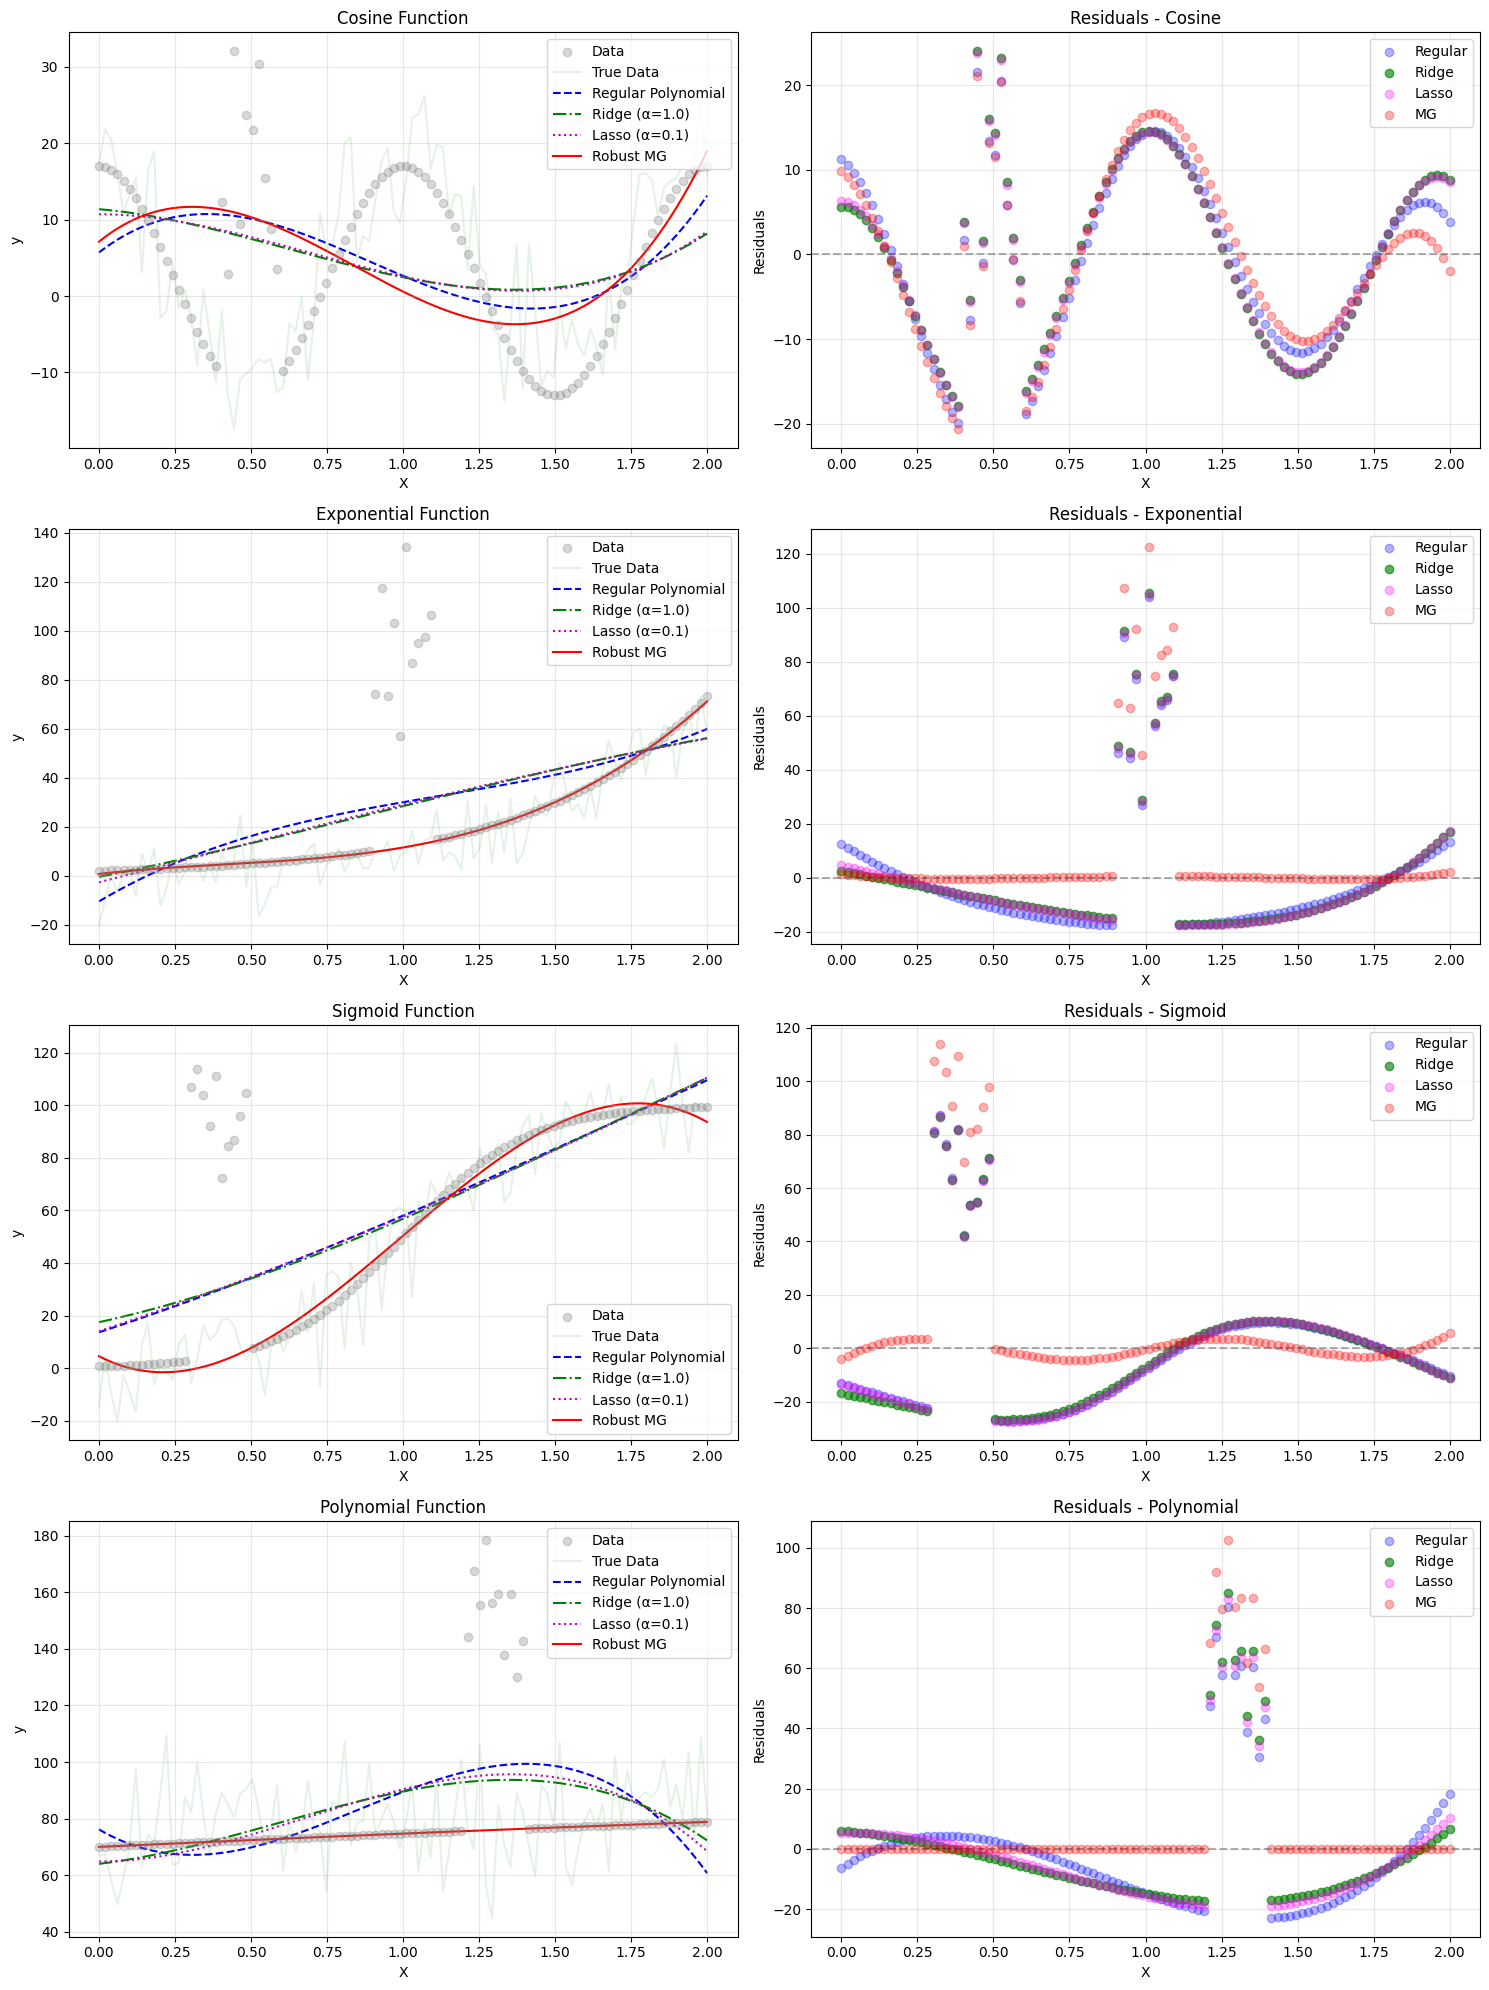

In [21]:
# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 100).reshape(-1, 1)
    y, y_clean = generate_data(func, X, test_profiles[func])
    X_test = np.linspace(0, 2, 200).reshape(-1, 1)
    
    # ... rest of the code remains the same ...
    
    # Fit models
    degree = 3  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2, alpha=0.3)
    # line plot -true data
    axes[i,0].plot(X, y_clean, color='g', alpha=0.1, label='True Data', zorder=2)
    # Highlight outliers
    # axes[i,0].scatter(X[[1, 2]], y[[1, 2]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.3)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.63)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.3)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.3)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 97.7294
Ridge Regression:   102.6656
Lasso Regression:   101.8404
Robust MG:          102.7064

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 474.6336
Ridge Regression:   483.2078
Lasso Regression:   480.9685
Robust MG:          599.1925

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 675.9240
Ridge Regression:   675.6121
Lasso Regression:   675.7231
Robust MG:          927.3002

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 621.3686
Ridge Regression:   657.7784
Lasso Regression:   640.2269
Robust MG:          869.1502


/Users/nirmal/Documents/np_research/ManGo_code/ManGo/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.328e+01, tolerance: 8.013e+00
  model = cd_fast.enet_coordinate_descent(


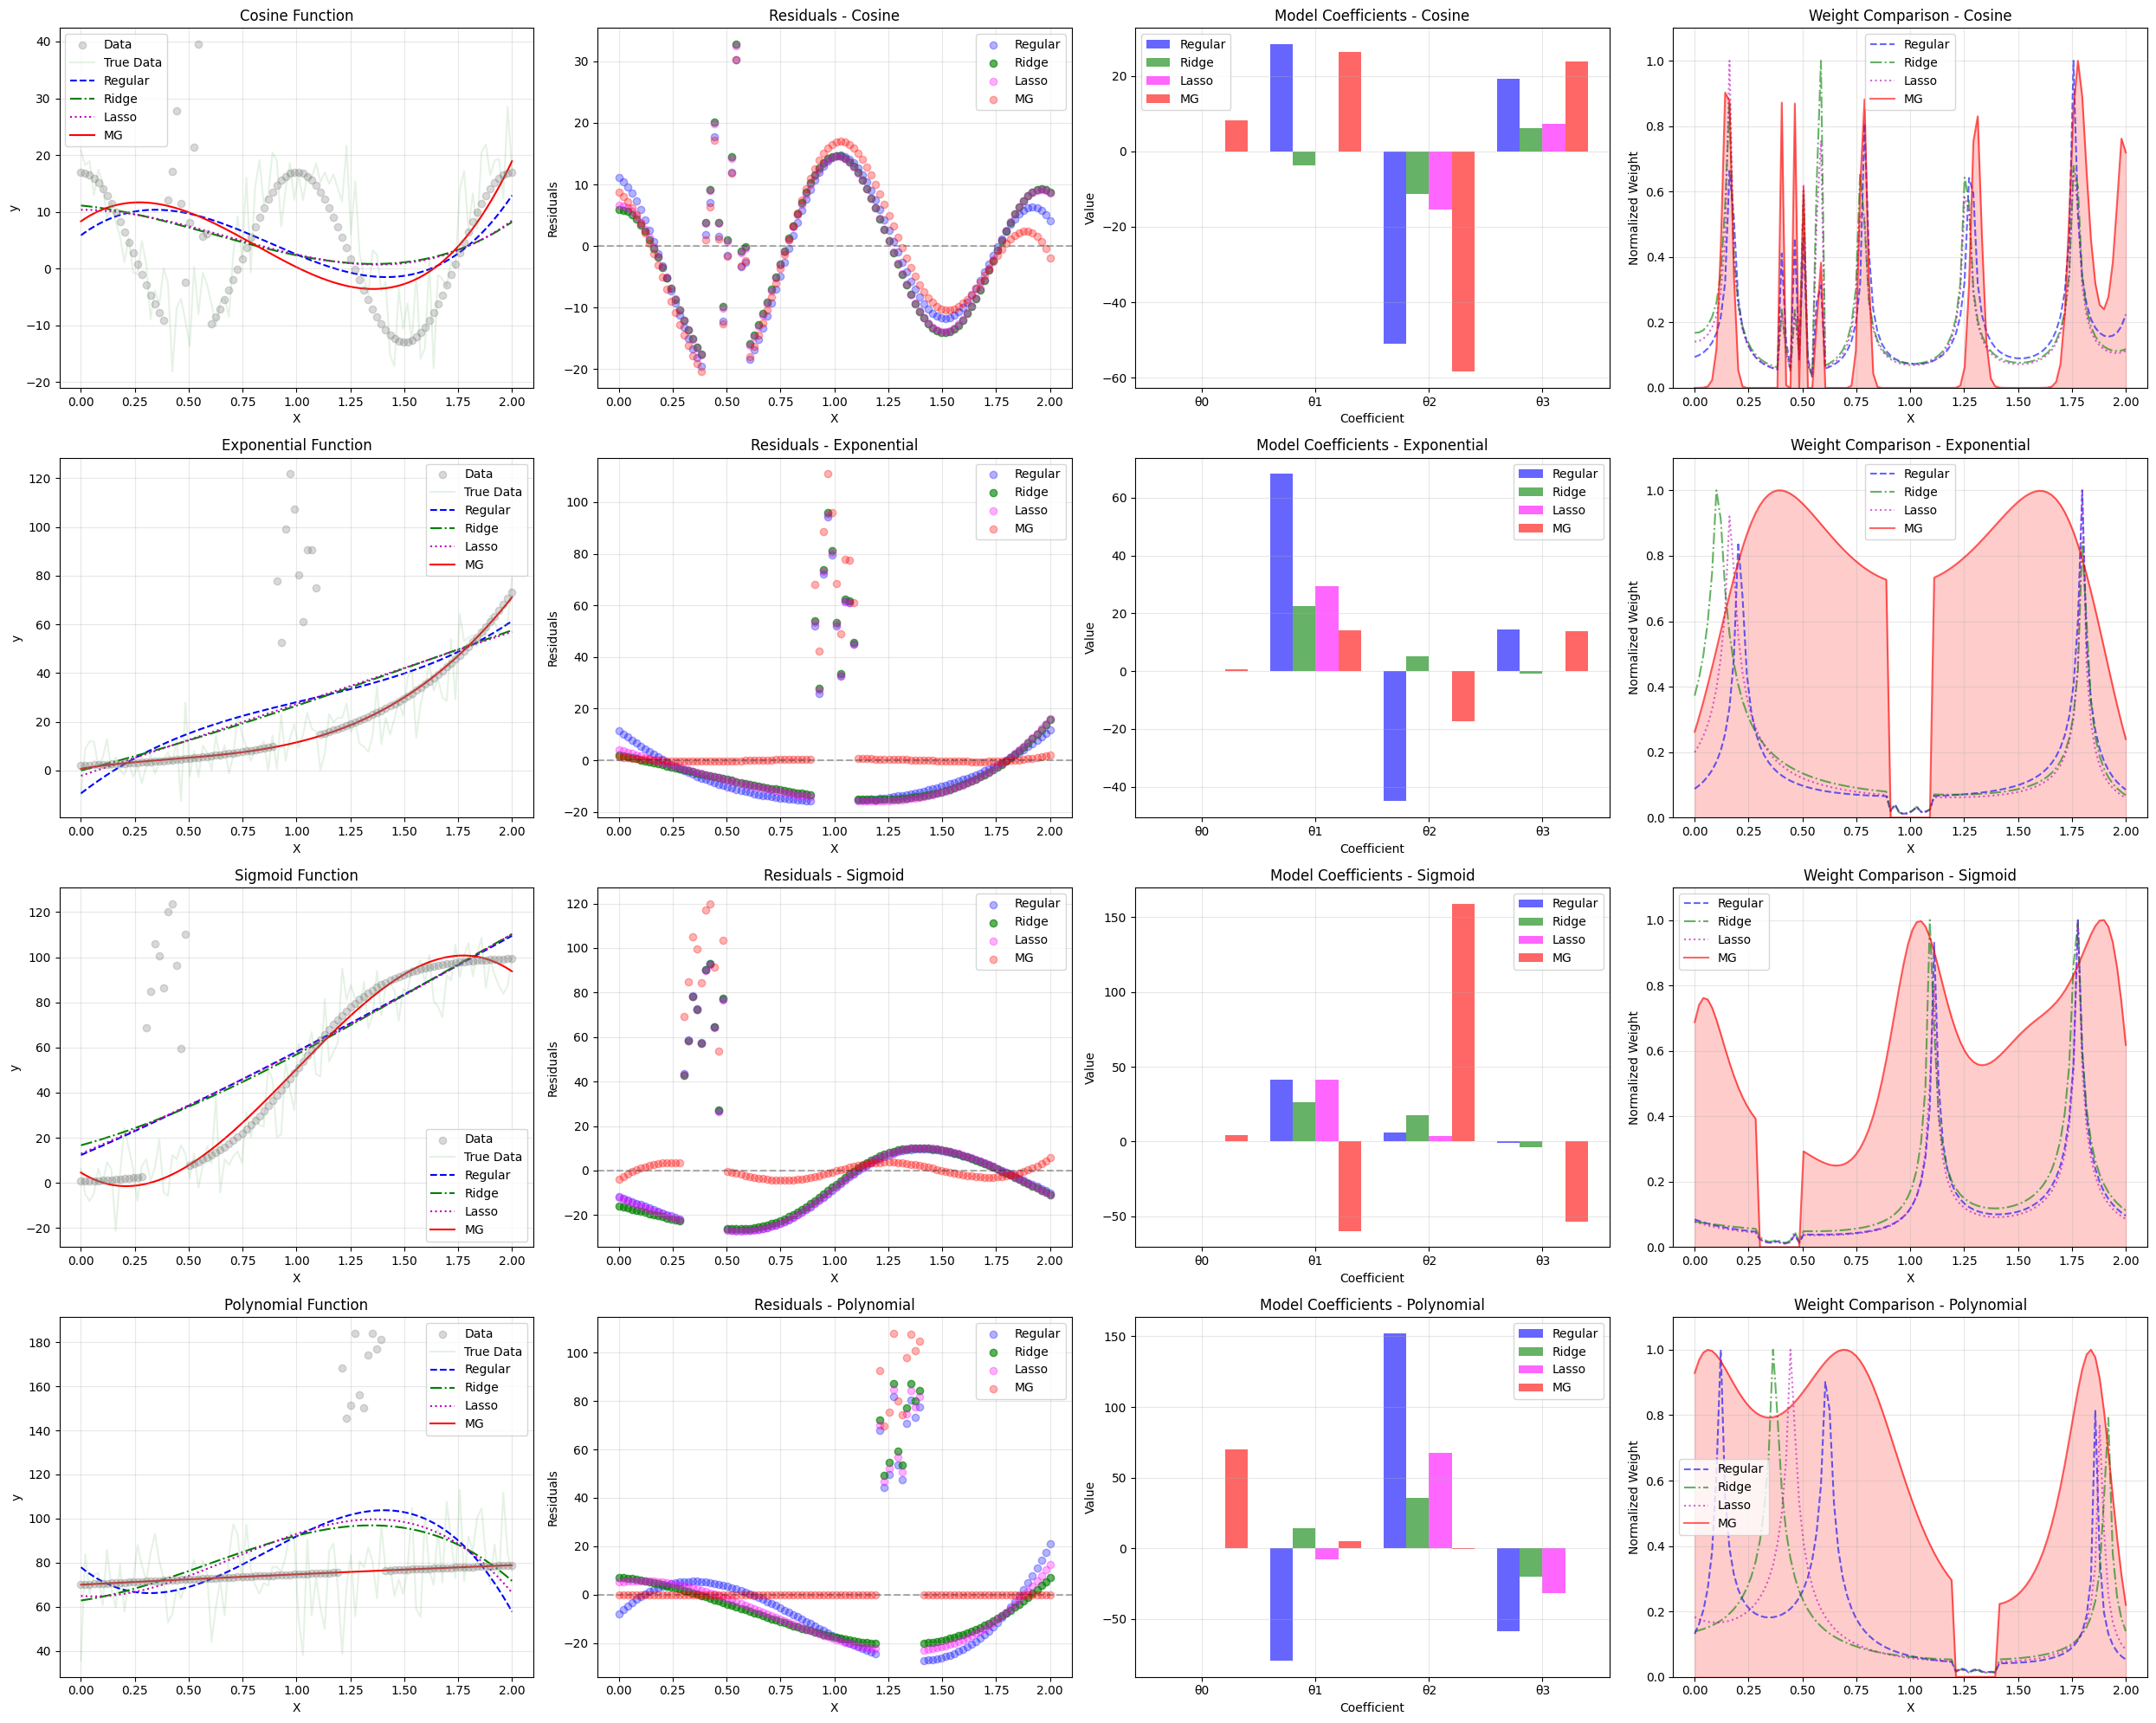

In [22]:
# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 4, figsize=(25, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 100).reshape(-1, 1)
    y, y_clean = generate_data(func, X, test_profiles[func])
    X_test = np.linspace(0, 2, 200).reshape(-1, 1)
    
    # Fit models
    degree = 3  # Reduced degree due to fewer points
    
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = PolynomialRegressor(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves (first subplot)
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2, alpha=0.3)
    axes[i,0].plot(X, y_clean, color='g', alpha=0.1, label='True Data', zorder=2)
    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals (second subplot)
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.3)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.63)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.3)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.3)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Plot coefficients comparison (third subplot)
    coef_names = [f'θ{j}' for j in range(degree + 1)]
    x_pos = np.arange(len(coef_names))
    width = 0.2
    
    # Get coefficients from all models
    regular_coef = poly_reg.named_steps['linearregression'].coef_
    ridge_coef = ridge_reg.named_steps['ridge'].coef_
    lasso_coef = lasso_reg.named_steps['lasso'].coef_
    mg_coef = mg_model.coefficients
    
    # Plot coefficients
    axes[i,2].bar(x_pos - 1.5*width, regular_coef, width, label='Regular', color='blue', alpha=0.6)
    axes[i,2].bar(x_pos - 0.5*width, ridge_coef, width, label='Ridge', color='green', alpha=0.6)
    axes[i,2].bar(x_pos + 0.5*width, lasso_coef, width, label='Lasso', color='magenta', alpha=0.6)
    axes[i,2].bar(x_pos + 1.5*width, mg_coef, width, label='MG', color='red', alpha=0.6)
    
    axes[i,2].set_xlabel('Coefficient')
    axes[i,2].set_ylabel('Value')
    axes[i,2].set_title(f'Model Coefficients - {func.capitalize()}')
    axes[i,2].set_xticks(x_pos)
    axes[i,2].set_xticklabels(coef_names)
    axes[i,2].legend()
    axes[i,2].grid(True, alpha=0.3)
    
    # Plot weights comparison (fourth subplot)
    # Use inverse of absolute residuals as weights for traditional methods
    reg_weights = 1 / (1 + np.abs(residuals_regular))
    ridge_weights = 1 / (1 + np.abs(residuals_ridge))
    lasso_weights = 1 / (1 + np.abs(residuals_lasso))
    
    # Normalize all weights to [0,1]
    reg_weights = reg_weights / np.max(reg_weights)
    ridge_weights = ridge_weights / np.max(ridge_weights)
    lasso_weights = lasso_weights / np.max(lasso_weights)
    mg_weights = mg_model.weights / np.max(mg_model.weights)
    
    axes[i,3].plot(X, reg_weights, 'b--', label='Regular', alpha=0.6)
    axes[i,3].plot(X, ridge_weights, 'g-.', label='Ridge', alpha=0.6)
    axes[i,3].plot(X, lasso_weights, 'm:', label='Lasso', alpha=0.6)
    axes[i,3].plot(X, mg_weights, 'r-', label='MG', alpha=0.6)
    axes[i,3].fill_between(X.ravel(), mg_weights, alpha=0.2, color='red')
    
    axes[i,3].set_xlabel('X')
    axes[i,3].set_ylabel('Normalized Weight')
    axes[i,3].set_title(f'Weight Comparison - {func.capitalize()}')
    axes[i,3].legend()
    axes[i,3].grid(True, alpha=0.3)
    axes[i,3].set_ylim(0, 1.1)

    # Calculate and print metrics
    good_indices = np.setdiff1d(np.arange(len(X)), outlier_positions)
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

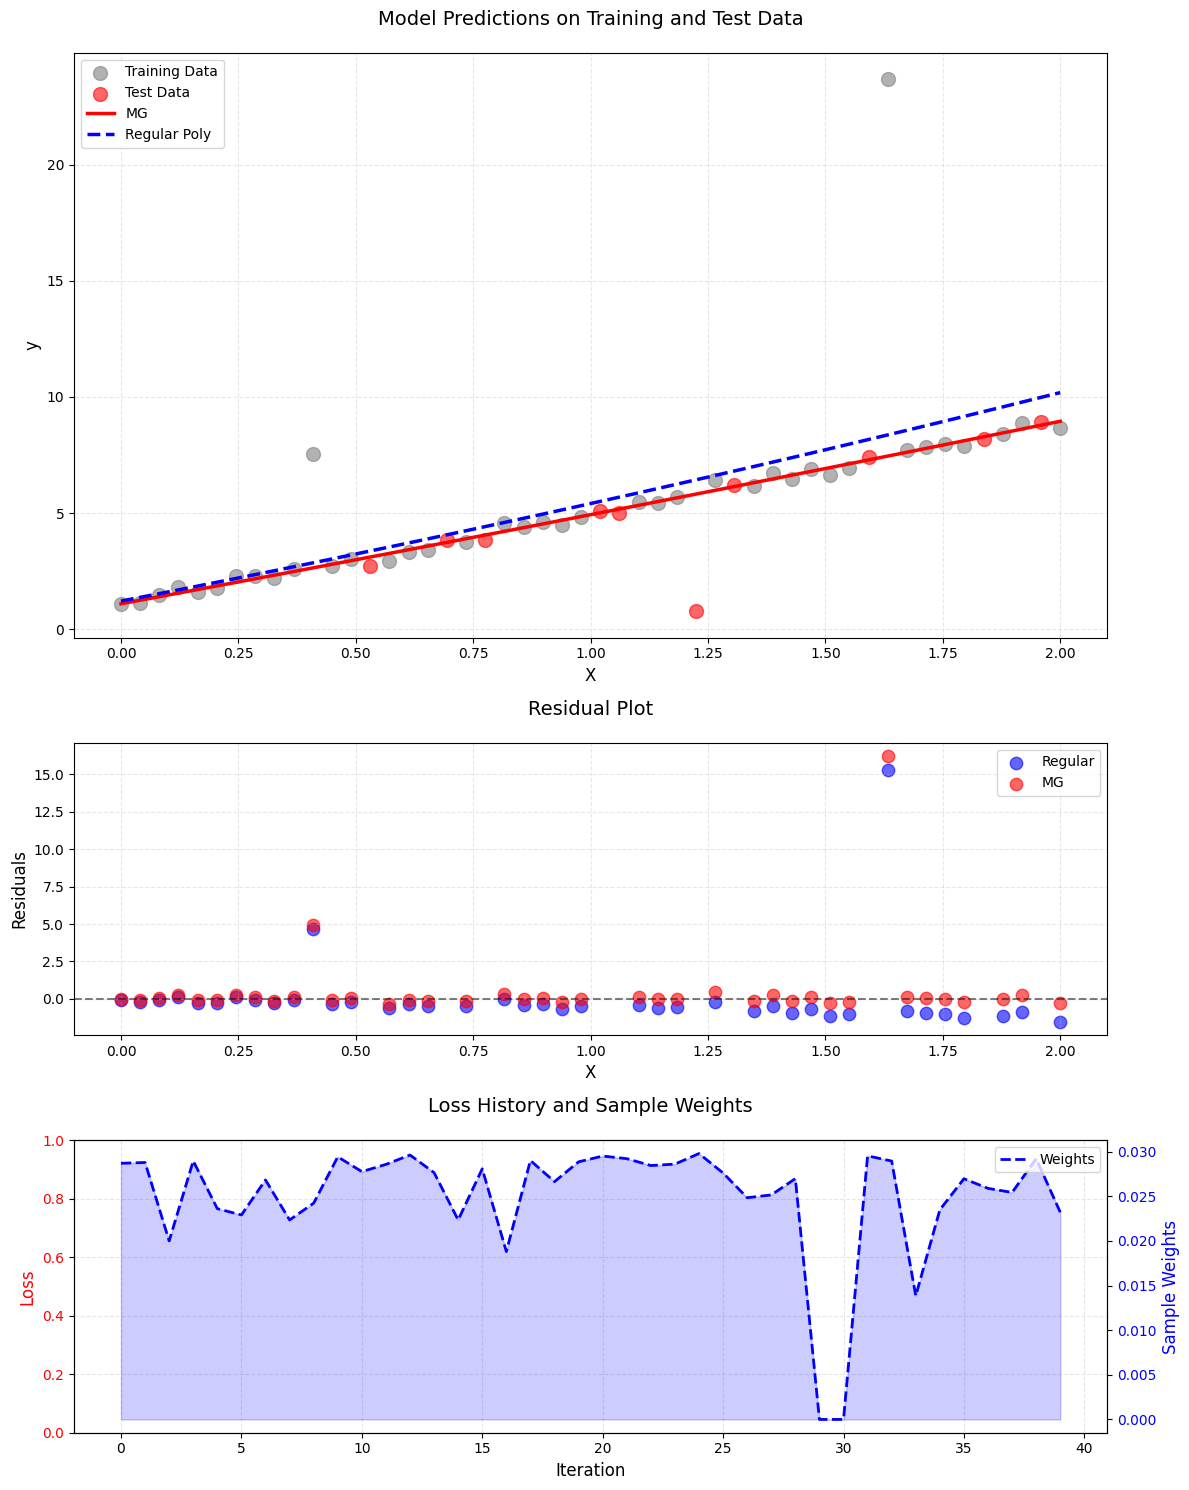


Performance Metrics:
--------------------------------------------------
Training Set:
MSE Regular:    6.8236
MSE MG:         7.2134

Test Set:
MSE Regular:    3.6831
MSE MG:         2.5673

Model Coefficients:
--------------------------------------------------
Regular: [0.         3.91104203 0.28940496]
MG:      [1.09278992 3.74522994 0.09247415]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
X = np.linspace(0, 2, 50).reshape(-1, 1)  # More points for smoother curves
noise = np.random.normal(0, 0.2, 50)
y = 4 * X.ravel() + 1 + noise  # Linear relationship with noise

# Add some outliers
outlier_idx = [10, 30, 40]
y[outlier_idx] += [5.0, -5.0, 16.0]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit models
degree = 2
# Regular polynomial regression
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X_train, y_train)
y_pred_regular_train = poly_reg.predict(X_train)
y_pred_regular_test = poly_reg.predict(X_test)

# Fit robust Machine Gnostics regression
mg_model = PolynomialRegressor(degree=degree, mg_loss='hi')
mg_model.fit(X_train, y_train)
y_pred_robust_train = mg_model.predict(X_train)
y_pred_robust_test = mg_model.predict(X_test)

# ...existing code...

# Create figure with subplots with adjusted height ratios
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[2, 1, 1])

# Plot 1: Training and Test Data with Predictions
ax1.scatter(X_train, y_train, c='gray', label='Training Data', alpha=0.6, s=100, zorder=2)
ax1.scatter(X_test, y_test, c='red', label='Test Data', alpha=0.6, s=100, zorder=2)

# Sort X values for smooth curve plotting
X_plot = np.sort(X_train, axis=0)
X_test_plot = np.sort(X_test, axis=0)

# Plot predictions with smoother curves
ax1.plot(X_plot, mg_model.predict(X_plot), 'r-', label='MG', linewidth=2.5, zorder=3)
ax1.plot(X_plot, poly_reg.predict(X_plot), 'b--', label='Regular Poly', linewidth=2.5, zorder=3)

ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('Model Predictions on Training and Test Data', fontsize=14, pad=20)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Residuals with clearer visualization
residuals_regular = y_train - poly_reg.predict(X_train)
residuals_robust = y_train - mg_model.predict(X_train)

ax2.scatter(X_train, residuals_regular, c='blue', label='Regular', alpha=0.6, s=80)
ax2.scatter(X_train, residuals_robust, c='red', label='MG', alpha=0.6, s=80)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, pad=20)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# Plot 3: Loss History with clearer weight visualization
# ax3.plot(mg_model._history, 'r-', label='Loss', linewidth=2)
ax3.set_xlabel('Iteration', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12, color='r')
ax3.set_title('Loss History and Sample Weights', fontsize=14, pad=20)
ax3.tick_params(axis='y', labelcolor='r')
ax3.grid(True, alpha=0.3, linestyle='--')

# Add sample weights on secondary y-axis with better formatting
ax3_twin = ax3.twinx()
ax3_twin.plot(range(len(X_train)), mg_model.weights, 'b--', label='Weights', linewidth=2)
ax3_twin.fill_between(range(len(X_train)), mg_model.weights, alpha=0.2, color='blue')
ax3_twin.set_ylabel('Sample Weights', fontsize=12, color='b')
ax3_twin.tick_params(axis='y', labelcolor='b')

# Add combined legend for loss and weights
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3_twin.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# ...existing code...

# Calculate training set metrics
mse_regular_train = np.mean((y_pred_regular_train - y_train)**2)
mse_robust_train = np.mean((y_pred_robust_train - y_train)**2)

# Calculate test set metrics
mse_regular_test = np.mean((y_pred_regular_test - y_test)**2)
mse_robust_test = np.mean((y_pred_robust_test - y_test)**2)

# Print metrics with better formatting
print("\nPerformance Metrics:")
print("-" * 50)
print("Training Set:")
print(f"{'MSE Regular:':<15} {mse_regular_train:.4f}")
print(f"{'MSE MG:':<15} {mse_robust_train:.4f}")

print("\nTest Set:")
print(f"{'MSE Regular:':<15} {mse_regular_test:.4f}")
print(f"{'MSE MG:':<15} {mse_robust_test:.4f}")

print("\nModel Coefficients:")
print("-" * 50)
print(f"Regular: {poly_reg.named_steps['linearregression'].coef_}")
print(f"MG:      {mg_model.coefficients}")

In [24]:
# Test and Example Script for cross_covariance Function
import numpy as np
from machinegnostics.metrics.cross_variance import cross_covariance

# Example 1: Simple test case
data_1 = np.array([1, 2, 3, 4, 5])
data_2 = np.array([5, 4, 3, 2, 1])
result = cross_covariance(data_1, data_2, case='i')
print(f"Example 1: Cross-covariance (case='i') = {result}")

# Example 2: Random data with case='j'
np.random.seed(42)  # For reproducibility
data_1 = np.random.normal(0, 1, 10)
data_2 = np.random.normal(0, 1, 10)
result = cross_covariance(data_1, data_2, case='j')
print(f"Example 2: Cross-covariance (case='j') = {result}")

# Example 3: Edge case with identical data
data_1 = np.array([1, 1, 1, 1, 1])
data_2 = np.array([1, 1, 1, 1, 1])
result = cross_covariance(data_1, data_2, case='i')
print(f"Example 3: Cross-covariance with identical data = {result}")

# Example 4: Edge case with zero variance
data_1 = np.array([0, 0, 0, 0, 0])
data_2 = np.array([1, 2, 3, 4, 5])
try:
    result = cross_covariance(data_1, data_2, case='i')
    print(f"Example 4: Cross-covariance with zero variance = {result}")
except ValueError as e:
    print(f"Example 4: Expected error for zero variance: {e}")

2025-09-24 09:57:28,264 | cross_covariance | WARNING | Data 1 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:28,289 | cross_covariance | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.


Example 1: Cross-covariance (case='i') = 0.3029389668541208


2025-09-24 09:57:28,501 | cross_covariance | WARNING | Data 1 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:28,504 | cross_covariance | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:28,513 | cross_covariance | WARNING | Data 1 is not homogeneous. Switching to S=1 for better results.
2025-09-24 09:57:28,515 | cross_covariance | WARNING | Data 2 is not homogeneous. Switching to S=1 for better results.


Example 2: Cross-covariance (case='j') = 9.897691906878245
Example 3: Cross-covariance with identical data = 3.999982898372853e-20
Example 4: Cross-covariance with zero variance = 1.1912894915745022e-20


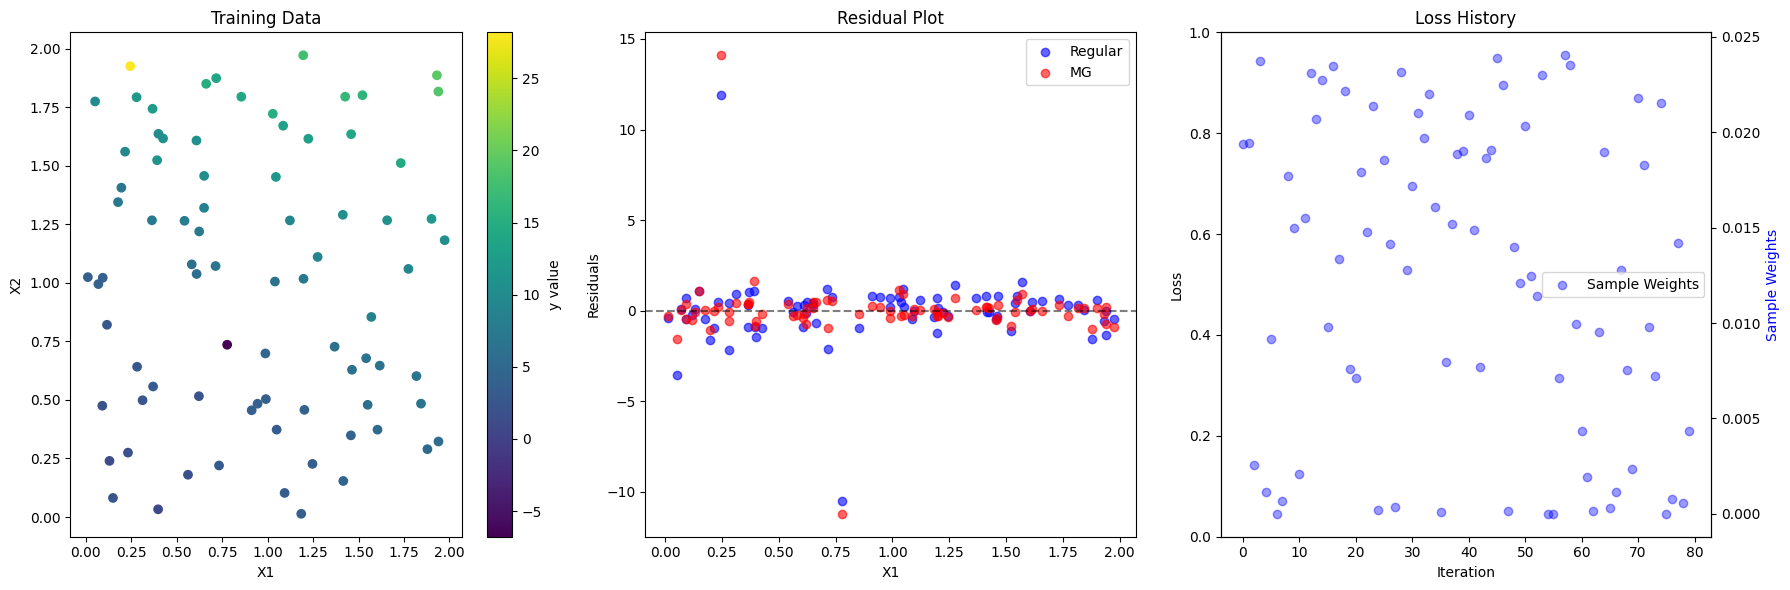


Performance Metrics:
--------------------------------------------------
Training Set:
MSE Regular:    3.9358
MSE MG:         4.3374

Test Set:
MSE Regular:    9.3166
MSE MG:         9.1186

Model Coefficients:
--------------------------------------------------
Regular: [ 0.          1.18933057 -2.42341029  0.9290668  -0.31875185  5.22193075]
MG:      [ 1.18590163  1.65820843 -0.80776098  0.3289148   0.64371796  3.70328696]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Generate 2D synthetic data
n_samples = 100
X1 = np.random.uniform(0, 2, n_samples)
X2 = np.random.uniform(0, 2, n_samples)
X = np.column_stack((X1, X2))

# True function: f(X1, X2) = 2*X1 + 3*X2^2 + X1*X2 + 1
y_clean = 2*X1 + 3*X2**2 + X1*X2 + 1

# Add noise
noise = np.random.normal(0, 0.5, n_samples)
y = y_clean + noise

# Add outliers
outlier_idx = [10, 30, 40, 60]
y[outlier_idx] += [8.0, -10.0, 15.0, -12.0]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit models
degree = 2
# Regular polynomial regression
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X_train, y_train)
y_pred_regular_train = poly_reg.predict(X_train)
y_pred_regular_test = poly_reg.predict(X_test)

# Fit robust Machine Gnostics regression
mg_model = PolynomialRegressor(degree=degree)
mg_model.fit(X_train, y_train)
y_pred_robust_train = mg_model.predict(X_train)
y_pred_robust_test = mg_model.predict(X_test)

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Training Data and Residuals
scatter = ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                     cmap='viridis', label='Training Data')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('Training Data')
plt.colorbar(scatter, ax=ax1, label='y value')

# Plot 2: Residuals Comparison
residuals_regular = y_train - y_pred_regular_train
residuals_robust = y_train - y_pred_robust_train

ax2.scatter(X_train[:, 0], residuals_regular, c='blue', label='Regular', alpha=0.6)
ax2.scatter(X_train[:, 0], residuals_robust, c='red', label='MG', alpha=0.6)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.legend()

# Plot 3: Loss History and Sample Weights
# ax3.plot(mg_model._history, 'r-', label='Loss')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Loss')
ax3.set_title('Loss History')

# Add sample weights visualization
ax3_twin = ax3.twinx()
ax3_twin.scatter(range(len(X_train)), mg_model.weights, c='blue', 
                alpha=0.4, label='Sample Weights')
ax3_twin.set_ylabel('Sample Weights', color='blue')

# Combine legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3_twin.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("-" * 50)
print("Training Set:")
print(f"{'MSE Regular:':<15} {np.mean((y_pred_regular_train - y_train)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y_pred_robust_train - y_train)**2):.4f}")

print("\nTest Set:")
print(f"{'MSE Regular:':<15} {np.mean((y_pred_regular_test - y_test)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y_pred_robust_test - y_test)**2):.4f}")

print("\nModel Coefficients:")
print("-" * 50)
print(f"Regular: {poly_reg.named_steps['linearregression'].coef_}")
print(f"MG:      {mg_model.coefficients}")

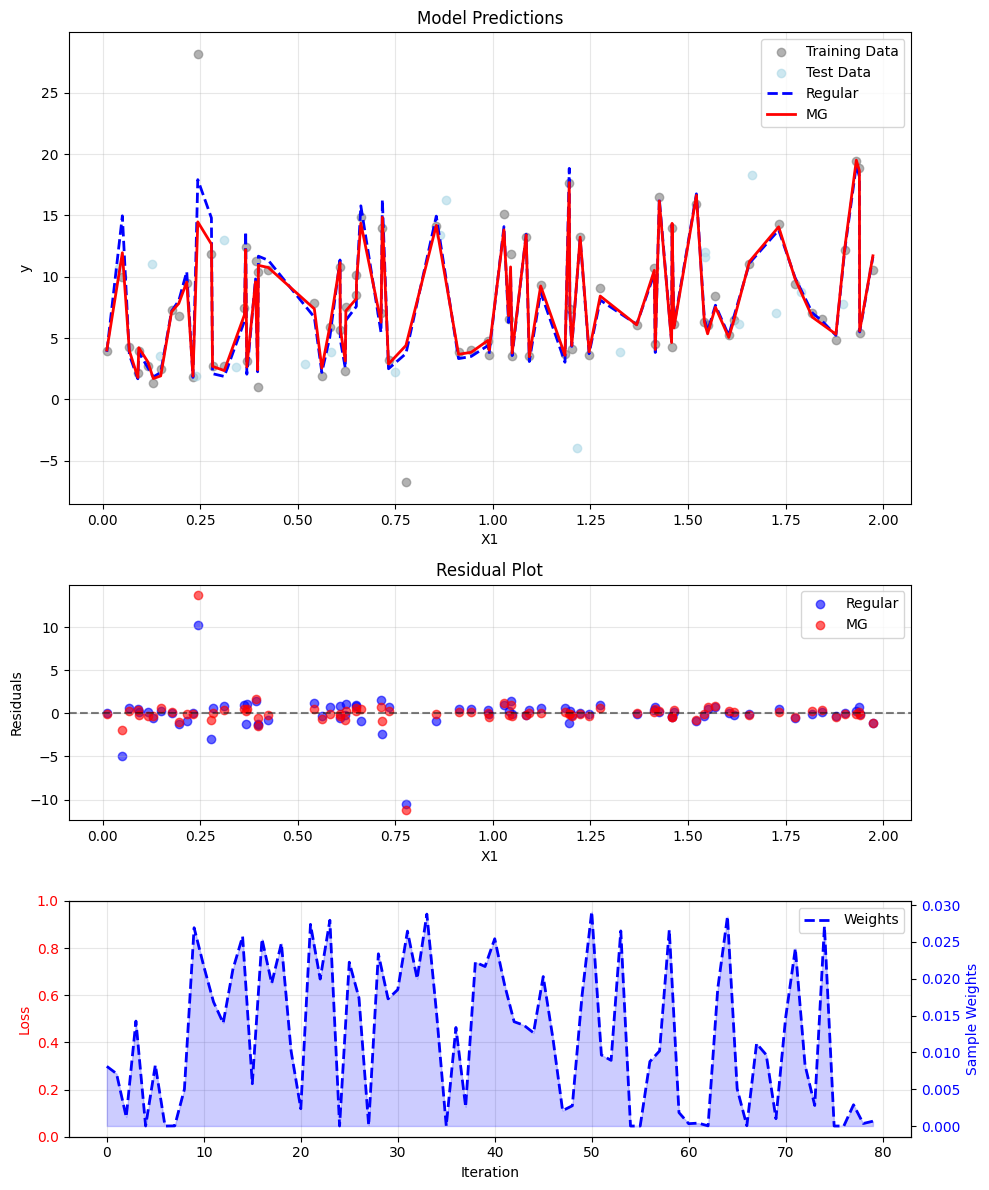


Performance Metrics:
--------------------------------------------------
Training Set:
MSE Regular:    3.6427
MSE MG:         4.2104

Test Set:
MSE Regular:    10.2418
MSE MG:         9.2837


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from machinegnostics.models.regression import PolynomialRegressor

# Set random seed for reproducibility
np.random.seed(42)

# Generate 2D synthetic data
n_samples = 100
X1 = np.random.uniform(0, 2, n_samples)
X2 = np.random.uniform(0, 2, n_samples)
X = np.column_stack((X1, X2))

# True function: f(X1, X2) = 2*X1 + 3*X2^2 + X1*X2 + 1
y_clean = 2*X1 + 3*X2**2 + X1*X2 + 1

# Add noise
noise = np.random.normal(0, 0.5, n_samples)
y = y_clean + noise

# Add outliers
outlier_idx = [10, 30, 40, 60]
y[outlier_idx] += [8.0, -10.0, 15.0, -12.0]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit models
degree = 3
# Regular polynomial regression
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X_train, y_train)
y_pred_regular_train = poly_reg.predict(X_train)
y_pred_regular_test = poly_reg.predict(X_test)

# Fit robust Machine Gnostics regression
mg_model = PolynomialRegressor(degree=degree)
mg_model.fit(X_train, y_train)
y_pred_robust_train = mg_model.predict(X_train)
y_pred_robust_test = mg_model.predict(X_test)

# Create figure with subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), height_ratios=[2, 1, 1])

# Plot 1: Regression Plot (using X1 as x-axis)
ax1.scatter(X_train[:, 0], y_train, c='gray', label='Training Data', alpha=0.6)
ax1.scatter(X_test[:, 0], y_test, c='lightblue', label='Test Data', alpha=0.6)
sort_idx = np.argsort(X_train[:, 0])
ax1.plot(X_train[sort_idx, 0], y_pred_regular_train[sort_idx], 'b--', 
         label='Regular', linewidth=2)
ax1.plot(X_train[sort_idx, 0], y_pred_robust_train[sort_idx], 'r-', 
         label='MG', linewidth=2)
ax1.set_xlabel('X1')
ax1.set_ylabel('y')
ax1.set_title('Model Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
residuals_regular = y_train - y_pred_regular_train
residuals_robust = y_train - y_pred_robust_train

ax2.scatter(X_train[:, 0], residuals_regular, c='blue', label='Regular', alpha=0.6)
ax2.scatter(X_train[:, 0], residuals_robust, c='red', label='MG', alpha=0.6)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('X1')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Loss History with Sample Weights
# ax3.plot(mg_model._history, 'r-', label='Loss', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Loss', color='r')
ax3.tick_params(axis='y', labelcolor='r')
ax3.grid(True, alpha=0.3)

# Add sample weights on secondary y-axis
ax3_twin = ax3.twinx()
ax3_twin.plot(range(len(X_train)), mg_model.weights, 'b--', 
              label='Weights', linewidth=2)
ax3_twin.fill_between(range(len(X_train)), mg_model.weights, 
                      alpha=0.2, color='blue')
ax3_twin.set_ylabel('Sample Weights', color='b')
ax3_twin.tick_params(axis='y', labelcolor='b')

# Combine legends for loss plot
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("-" * 50)
print("Training Set:")
print(f"{'MSE Regular:':<15} {np.mean((y_pred_regular_train - y_train)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y_pred_robust_train - y_train)**2):.4f}")

print("\nTest Set:")
print(f"{'MSE Regular:':<15} {np.mean((y_pred_regular_test - y_test)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y_pred_robust_test - y_test)**2):.4f}")

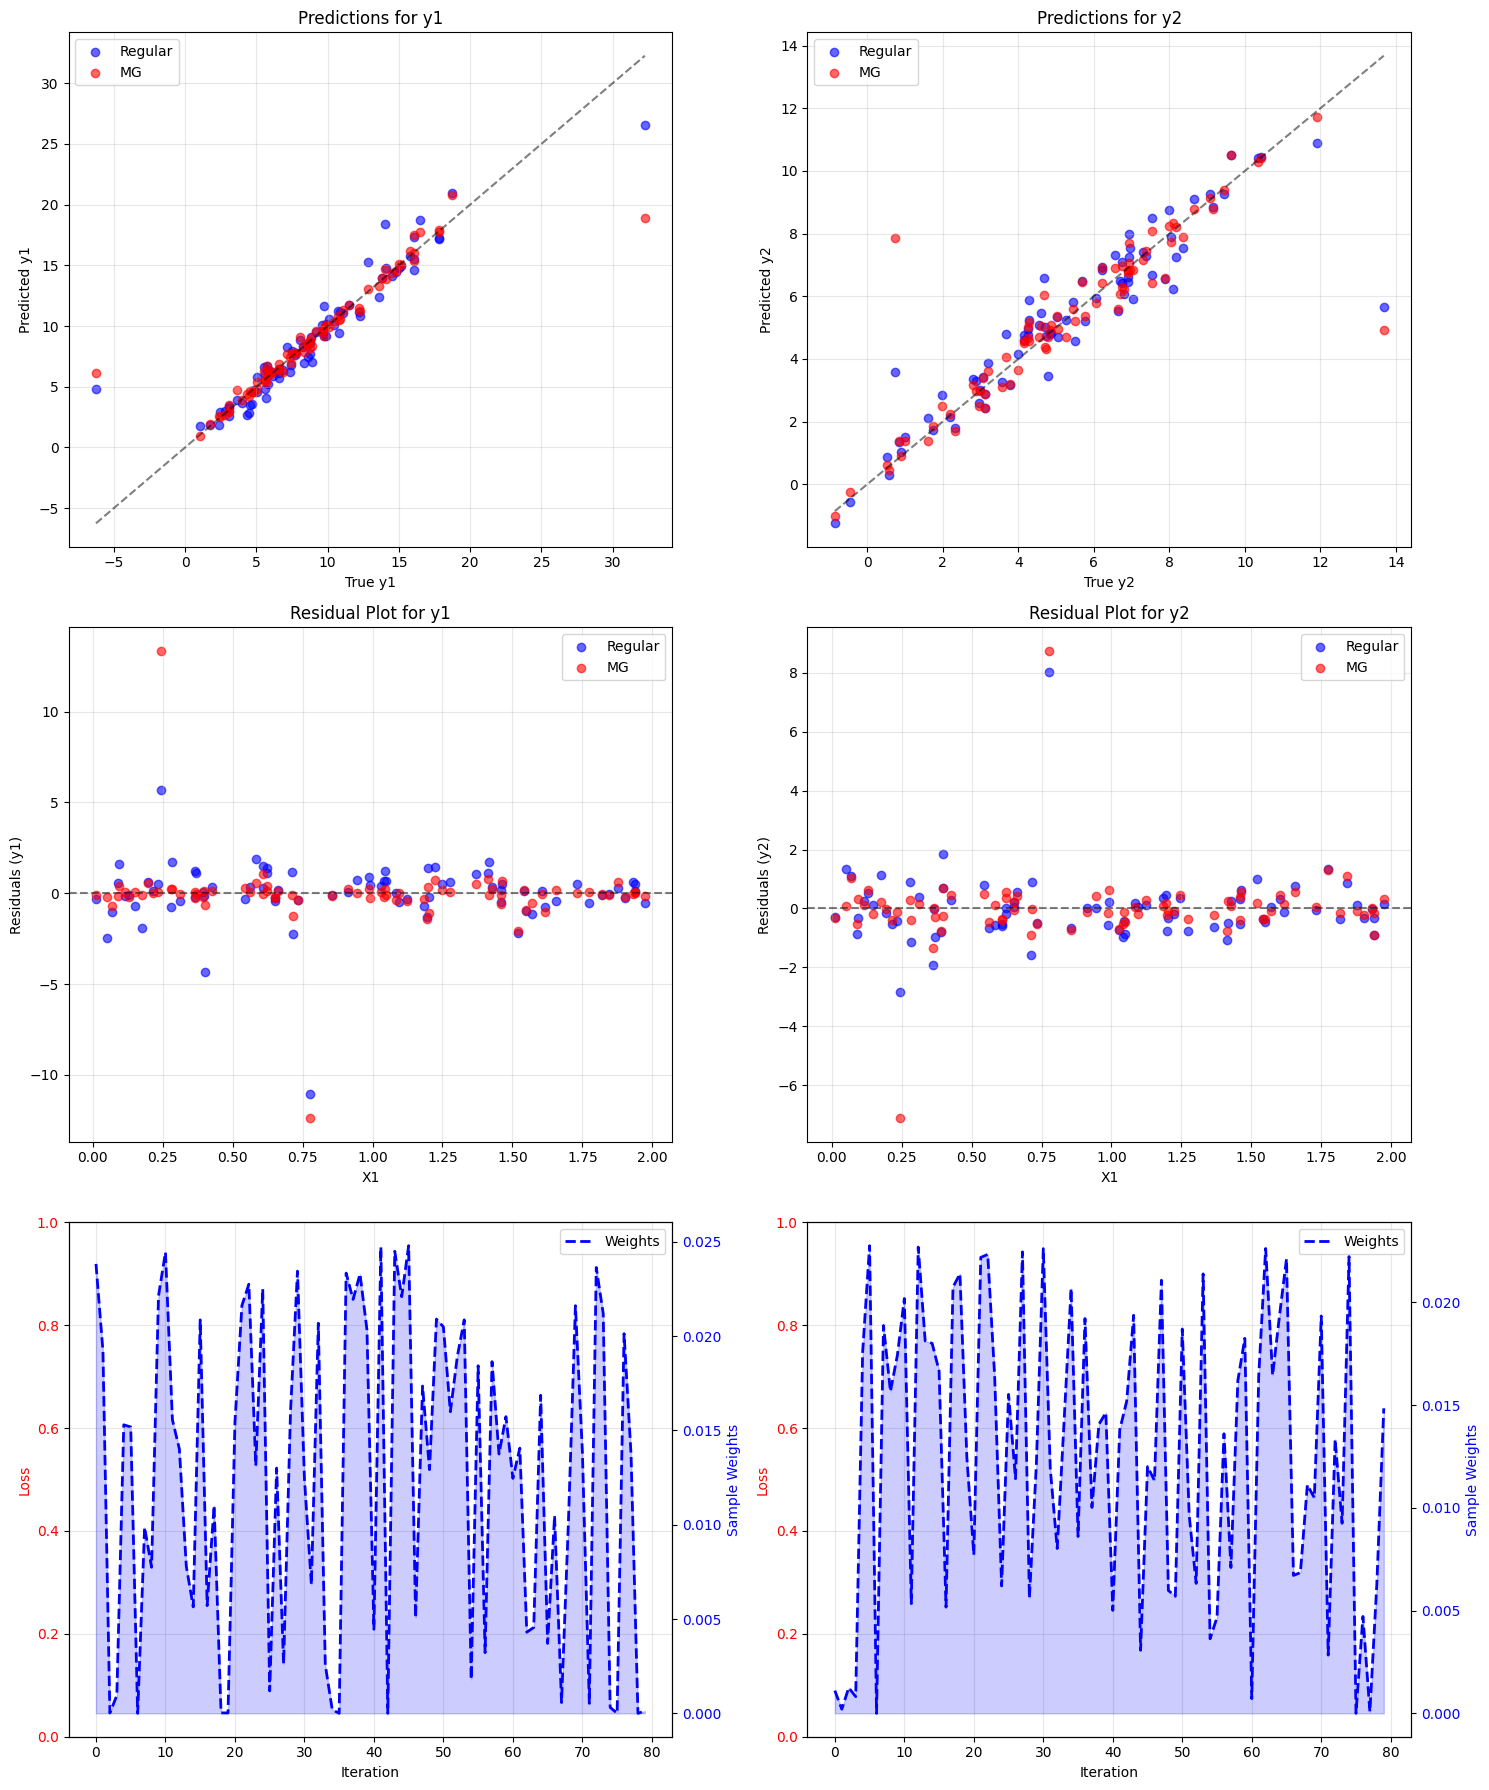


Performance Metrics:
--------------------------------------------------
Training Set:
y1:
MSE Regular:    2.9793
MSE MG:         4.3825

y2:
MSE Regular:    1.3689
MSE MG:         1.8029

Test Set:
y1:
MSE Regular:    11.0243
MSE MG:         11.1092

y2:
MSE Regular:    17.8723
MSE MG:         18.2368


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from machinegnostics.models.regression import PolynomialRegressor
# Set random seed for reproducibility
np.random.seed(42)

# Generate 3D synthetic data
n_samples = 100
X1 = np.random.uniform(0, 2, n_samples)
X2 = np.random.uniform(0, 2, n_samples)
X3 = np.random.uniform(0, 2, n_samples)
X = np.column_stack((X1, X2, X3))

# True functions: 
# y1 = 2*X1 + 3*X2^2 + X1*X3 + X2*X3 + 1
# y2 = X1^2 + 2*X2 + 3*X3 + X1*X2 - 2
y1_clean = 2*X1 + 3*X2**2 + X1*X3 + X2*X3 + 1
y2_clean = X1**2 + 2*X2 + 3*X3 + X1*X2 - 2

# Add noise
noise1 = np.random.normal(0, 0.5, n_samples)
noise2 = np.random.normal(0, 0.5, n_samples)
y1 = y1_clean + noise1
y2 = y2_clean + noise2

# Add outliers
outlier_idx = [10, 30, 40, 60]
y1[outlier_idx] += [8.0, -10.0, 15.0, -12.0]
y2[outlier_idx] += [-12.0, 15.0, -8.0, 10.0]

# Split data
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y1, y2, test_size=0.2, random_state=42)

# Fit models for y1 and y2
degree = 3

# Regular polynomial regression
poly_reg1 = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg2 = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_reg1.fit(X_train, y1_train)
poly_reg2.fit(X_train, y2_train)

y1_pred_regular_train = poly_reg1.predict(X_train)
y1_pred_regular_test = poly_reg1.predict(X_test)
y2_pred_regular_train = poly_reg2.predict(X_train)
y2_pred_regular_test = poly_reg2.predict(X_test)

# Fit robust Machine Gnostics regression
mg_model1 = PolynomialRegressor(degree=degree)
mg_model2 = PolynomialRegressor(degree=degree)

mg_model1.fit(X_train, y1_train)
mg_model2.fit(X_train, y2_train)

y1_pred_robust_train = mg_model1.predict(X_train)
y1_pred_robust_test = mg_model1.predict(X_test)
y2_pred_robust_train = mg_model2.predict(X_train)
y2_pred_robust_test = mg_model2.predict(X_test)

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot predictions for y1 and y2
for idx, (y_train, y_test, y_pred_regular_train, y_pred_robust_train, title) in enumerate([
    (y1_train, y1_test, y1_pred_regular_train, y1_pred_robust_train, 'y1'),
    (y2_train, y2_test, y2_pred_regular_train, y2_pred_robust_train, 'y2')
]):
    # Predictions plot
    axes[0, idx].scatter(y_train, y_pred_regular_train, c='blue', 
                        label='Regular', alpha=0.6)
    axes[0, idx].scatter(y_train, y_pred_robust_train, c='red', 
                        label='MG', alpha=0.6)
    axes[0, idx].plot([y_train.min(), y_train.max()], 
                     [y_train.min(), y_train.max()], 'k--', alpha=0.5)
    axes[0, idx].set_xlabel(f'True {title}')
    axes[0, idx].set_ylabel(f'Predicted {title}')
    axes[0, idx].set_title(f'Predictions for {title}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Residuals plot
    residuals_regular = y_train - y_pred_regular_train
    residuals_robust = y_train - y_pred_robust_train
    
    axes[1, idx].scatter(X_train[:, 0], residuals_regular, c='blue', 
                        label='Regular', alpha=0.6)
    axes[1, idx].scatter(X_train[:, 0], residuals_robust, c='red', 
                        label='MG', alpha=0.6)
    axes[1, idx].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, idx].set_xlabel('X1')
    axes[1, idx].set_ylabel(f'Residuals ({title})')
    axes[1, idx].set_title(f'Residual Plot for {title}')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

    # Loss and weights plot
    mg_model = mg_model1 if idx == 0 else mg_model2
    ax = axes[2, idx]
    # ax.plot(mg_model._history, 'r-', label='Loss', linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss', color='r')
    ax.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)

    # Add sample weights
    ax_twin = ax.twinx()
    ax_twin.plot(range(len(X_train)), mg_model.weights, 'b--', 
                label='Weights', linewidth=2)
    ax_twin.fill_between(range(len(X_train)), mg_model.weights, 
                        alpha=0.2, color='blue')
    ax_twin.set_ylabel('Sample Weights', color='b')
    ax_twin.tick_params(axis='y', labelcolor='b')

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_twin.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("-" * 50)
print("Training Set:")
print("y1:")
print(f"{'MSE Regular:':<15} {np.mean((y1_pred_regular_train - y1_train)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y1_pred_robust_train - y1_train)**2):.4f}")
print("\ny2:")
print(f"{'MSE Regular:':<15} {np.mean((y2_pred_regular_train - y2_train)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y2_pred_robust_train - y2_train)**2):.4f}")

print("\nTest Set:")
print("y1:")
print(f"{'MSE Regular:':<15} {np.mean((y1_pred_regular_test - y1_test)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y1_pred_robust_test - y1_test)**2):.4f}")
print("\ny2:")
print(f"{'MSE Regular:':<15} {np.mean((y2_pred_regular_test - y2_test)**2):.4f}")
print(f"{'MSE MG:':<15} {np.mean((y2_pred_robust_test - y2_test)**2):.4f}")